# CprE 487/587 Lab 1 - CNN TinyImageNet Template

This notebook contains the template for Lab 1 focusing on CNN inference and training with TinyImageNet dataset.

## Environment Verification

Before running the main code, let's verify that all required packages are available.

In [4]:
# Environment Verification Cell
import sys
import importlib.util

def check_package(package_name, import_name=None):
    """Check if a package is available"""
    if import_name is None:
        import_name = package_name

    try:
        spec = importlib.util.find_spec(import_name)
        if spec is not None:
            print(f"✓ {package_name} is available")
            return True
        else:
            print(f"✗ {package_name} is NOT available")
            return False
    except ImportError:
        print(f"✗ {package_name} is NOT available")
        return False

print("Environment Verification:")
print(f"Python version: {sys.version}")
print()

# Check required packages
required_packages = [
    ("NumPy", "numpy"),
    ("TensorFlow", "tensorflow"),
    ("Matplotlib", "matplotlib"),
    ("TensorFlow Datasets", "tensorflow_datasets"),
    ("Tiny ImageNet TFDS", "tiny_imagenet"),
    ("Pillow", "PIL"),
    ("Jupyter", "jupyter"),
    ("Keras", "keras")
]

all_available = True
for package_name, import_name in required_packages:
    available = check_package(package_name, import_name)
    if not available:
        all_available = False

print()
if all_available:
    print("✓ All required packages are available. You can proceed with the notebook.")
else:
    print("✗ Some packages are missing. Please install them before proceeding.")
    print("You may need to run: pip install tensorflow tensorflow-datasets matplotlib pillow tiny-imagenet-tfds")

print()
print("If you encounter any issues:")
print("1. Make sure you're using the 'new_lab_env' Python environment")
print("2. Check that all required files (CNN_TinyImageNet.h5, wnids.txt, words.txt) are in the same directory")
print("3. Verify that you have sufficient disk space for the TinyImageNet dataset download")

Environment Verification:
Python version: 3.9.21 (main, Feb 10 2025, 00:00:00) 
[GCC 11.5.0 20240719 (Red Hat 11.5.0-5)]

✓ NumPy is available
✓ TensorFlow is available
✓ Matplotlib is available
✓ TensorFlow Datasets is available
✓ Tiny ImageNet TFDS is available
✓ Pillow is available
✓ Jupyter is available
✓ Keras is available

✓ All required packages are available. You can proceed with the notebook.

If you encounter any issues:
1. Make sure you're using the 'new_lab_env' Python environment
2. Check that all required files (CNN_TinyImageNet.h5, wnids.txt, words.txt) are in the same directory
3. Verify that you have sufficient disk space for the TinyImageNet dataset download


## Tools Setup

In [5]:
import pathlib, os, sys, operator, re, datetime
from functools import reduce
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from tensorflow import keras
from keras import Model
import tensorflow_datasets as tfds
from tiny_imagenet import TinyImagenetDataset

# Enable or disable GPU
# To fully disable it, we need to hide all GPU devices from Tensorflow
# Make sure GPU is disabled for this inference part of the lab
ENABLE_GPU = True
# tf.debugging.set_log_device_placement(True)

if not ENABLE_GPU:
    tf.config.set_visible_devices([], 'GPU')

# Print Python and TF version, and where we are running
print(f'Running on Python Version: {sys.version}')
print(f'Using Tensorflow Version: {tf. __version__}')
if not tf.config.experimental.list_physical_devices("GPU"):
    print('Running on CPU')
else:
    print(f'Using GPU at: {tf.test.gpu_device_name()} (of {len(tf.config.experimental.list_physical_devices("GPU"))} available)')

Running on Python Version: 3.9.21 (main, Feb 10 2025, 00:00:00) 
[GCC 11.5.0 20240719 (Red Hat 11.5.0-5)]
Using Tensorflow Version: 2.16.2
Running on CPU


## Dataset Inspection

In [6]:
# This cell imports our dataset.

# Original Source: https://github.com/ksachdeva/tiny-imagenet-tfds
# Class Version Source: https://github.com/duweisu/tiny-imagenet-tfds
# Setup our dataset
# ---------------------------------------------------------

tiny_imagenet_builder = TinyImagenetDataset()

# this call (download_and_prepare) will trigger the download of the dataset
# and preparation (conversion to tfrecords)
#
# This will be done only once and on next usage tfds will
# use the cached version on your host.
tiny_imagenet_builder.download_and_prepare(download_dir="~/tensorflow-datasets/downloads")

# class_names = tiny_imagenet_builder.info.features['label'].names
ds = tiny_imagenet_builder.as_dataset()
ds_train, ds_val = ds["train"], ds["validation"]
assert(isinstance(ds_train, tf.data.Dataset))
assert(isinstance(ds_val, tf.data.Dataset))

# Training Dataset
ds_train = ds_train.shuffle(1024).prefetch(tf.data.AUTOTUNE)

# Validation Dataset
ds_val = ds_val.shuffle(1024).prefetch(tf.data.AUTOTUNE)

# Dataset metadata
ds_info = tiny_imagenet_builder.info

In [7]:
# Helper function to get the label name
def img_class(img_data, idx=None):
    image, label, id, label_name = img_data["image"], img_data["label"], img_data["id"], img_data["metadata"]['label_name']
    # Handle batches of images correctly
    if idx != None:
        image, label, id, label_name = img_data["image"][idx], img_data["label"][idx], img_data["id"][idx], img_data["metadata"]['label_name'][idx]

    return f"{label_name} (class index: {label} - id: {id})"


# Helper function to show basic info about an image
def img_info(img, idx=None, display=True, title_apend=""):
    image = img['image']

    # Print the class
    class_str = img_class(img, idx)
    print(f"Label: {class_str}")

    # Display the image
    if display:
        plt.figure()
        plt.title(title_apend + class_str)
        # Handle batches correctly
        if image.shape.ndims > 3:
            plt.imshow(image.numpy().reshape(64, 64, 3))
        else:
            plt.imshow(image.numpy())

In [8]:
# We need to read the "human readable" labels so we can translate with the numeric values
# Read the labels file (words.txt)

# Using jupyter server so needed to change to the lab directory
# %cd u:/cpre_587/lab1  # Uncomment if needed for your environment

with open(os.path.abspath('wnids.txt'), 'r') as f:
    wnids = [x.strip() for x in f]

# Map wnids to integer labels
wnid_to_label = {wnid: i for i, wnid in enumerate(wnids)}
label_to_wnid = {v: k for k, v in wnid_to_label.items()}

# Use words.txt to get names for each class
with open(os.path.abspath('words.txt'), 'r') as f:
    wnid_to_words = dict(line.split('\t') for line in f)
    for wnid, words in wnid_to_words.items():
        wnid_to_words[wnid] = [w.strip() for w in words.split(',')]

class_names = [str(wnid_to_words[wnid]) for wnid in wnids]

FileNotFoundError: [Errno 2] No such file or directory: '/home/chilanaa/lab04/wnids.txt'

--- Train & Validation dataset info ---
Train: <_PrefetchDataset element_spec={'id': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'metadata': {'label_name': TensorSpec(shape=(), dtype=tf.string, name=None)}}>
Validation: <_PrefetchDataset element_spec={'id': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'metadata': {'label_name': TensorSpec(shape=(), dtype=tf.string, name=None)}}>
Dataset Info: tfds.core.DatasetInfo(
    name='tiny_imagenet_dataset',
    full_name='tiny_imagenet_dataset/0.2.0',
    description="""
    Tiny ImageNet Challenge is a similar challenge as ImageNet with a smaller dataset but
                             less image classes. It contains 200 image classes, a training
                             dataset of 

2025-11-04 14:51:26.970276: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-11-04 14:51:26.991097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-04 14:51:27.055580: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.

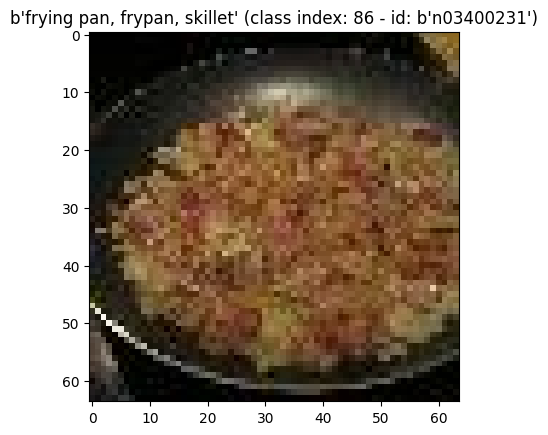

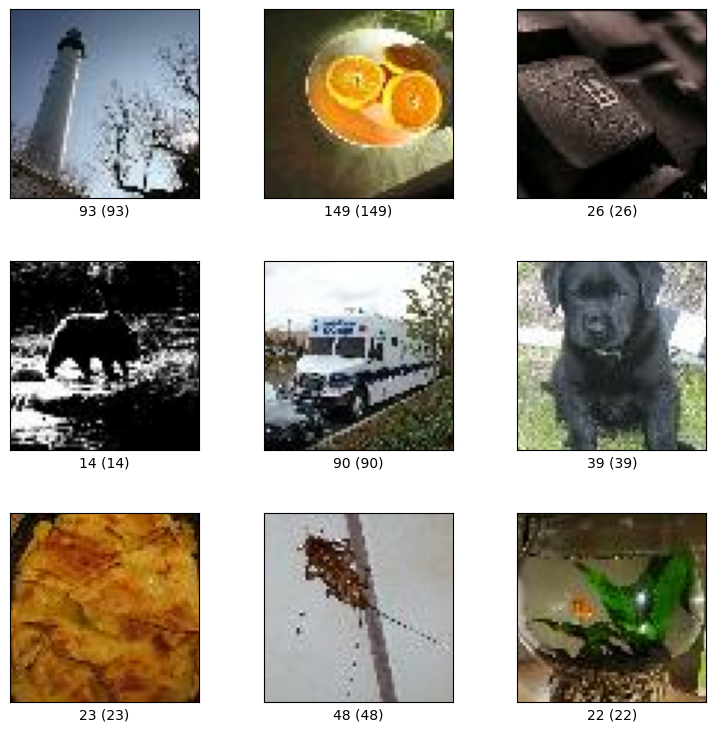

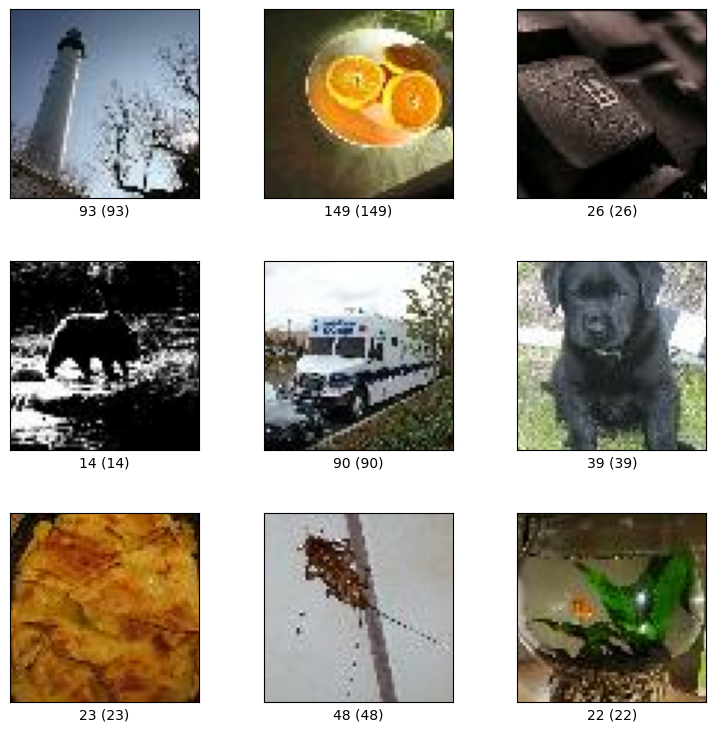

In [9]:
# Print the dataset types and info
print("--- Train & Validation dataset info ---")
print(f"Train: {ds_train}")
print(f"Validation: {ds_val}")
print(f"Dataset Info: {ds_info}") # Uncomment to print Dataset info

print("\n--- Show an example image ---")
for example in ds_val.take(1):
    img_info(example)

print("\n Show some other examples")
tfds.show_examples(ds_val, ds_info, rows=3, cols=3)

In [ ]:
# TODO: Print and visualize three inputs from the validation set
#     : Print the stroage data type
#     : Print and note the dimensions of each image
#     : Print the memory required to store each image

# Sample Images
sample_imgs = []
for index, img_data in enumerate(ds_val):
    sample_imgs.append(img_data)
    image, label, id, label_name = img_data["image"], img_data["label"], img_data["id"], img_data["metadata"]['label_name']

    print(f'\n--- Image {index} ---')
    print(f'Storage Data Type: {image.dtype}')
    print(f'Image Dimensions: {image.shape}')
    print(f'Memory Required to Store Image: {image.numpy().nbytes} bytes')
    # TODO: Your Code Here
    # See example usage: https://github.com/duweisu/tiny-imagenet-tfds


--- Image 0 ---
Storage Data Type: <dtype: 'uint8'>
Image Dimensions: (64, 64, 3)
Memory Required to Store Image: 12288 bytes

--- Image 1 ---
Storage Data Type: <dtype: 'uint8'>
Image Dimensions: (64, 64, 3)
Memory Required to Store Image: 12288 bytes

--- Image 2 ---
Storage Data Type: <dtype: 'uint8'>
Image Dimensions: (64, 64, 3)
Memory Required to Store Image: 12288 bytes


2025-11-04 14:51:33.115724: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-11-04 14:51:33.116893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
# TODO: Export each of the three inputs to a binary file which will be used to load the images into C++ later
# NOTE: First flatten the array (ex: 4D --> 1D). So 64*64*3 = 12288 element 1D array

# Make a directory for our image data
img_dir = os.path.abspath('img_data')
pathlib.Path(img_dir).mkdir(exist_ok=True)

# Create a metadata file
metadata_file = open(os.path.join(img_dir, f'metadata.txt'), 'w')
metadata_file.write(f'Number\t\tDims\t\tClass Data\n')

# Export each image
for index, img_data in enumerate(sample_imgs):
    image = img_data["image"]
    label = img_data["label"]
    label_name = img_data["metadata"]['label_name']

    # Write metadata
    metadata_file.write(f'{index}\t\t{image.shape}\t\t{label_name} (class {label})\n')

    # Export flattened image data
    img_file = open(os.path.join(img_dir, f'image_{index}.bin'), 'wb')
    flattened_image = tf.reshape(image, [-1])
    flattened_image.numpy().astype(np.float32).tofile(img_file)
    img_file.close()

    print(f'Exported image {index}: {image.shape} -> {flattened_image.shape} to image_{index}.bin')

# Close metadata file
metadata_file.close()
print(f'Metadata written to metadata.txt')

Exported image 0: (64, 64, 3) -> (12288,) to image_0.bin
Exported image 1: (64, 64, 3) -> (12288,) to image_1.bin
Exported image 2: (64, 64, 3) -> (12288,) to image_2.bin
Metadata written to metadata.txt


## Model Loading and Inference

In [13]:
# TODO: Load the model
# Now we will load the H5 model! Please make sure the h5 model file is present in the below directory.
# You can download this from the Canvas Page and place it in the same directory as this notebook.

# model_path = os.path.abspath(""/home/<NETID>/path/to/your/lab1/CNN_TinyImageNet.h5)" # Uncomment this to use a non-relative path
model_path = os.path.abspath("CNN_TinyImageNet.h5")

# TODO: Your Code Here
model = tf.keras.models.load_model(model_path)
model.summary()

/home/chilanaa/lab04/lab04_venv/lib64/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/chilanaa/lab04/lab04_venv/lib64/python3.9/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 60, 60, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        51,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 770,218 (2.94 MB)

 Trainable params: 770,216 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os

def analyze_weights_biases_keras(model, bins=80, show_plots=True, save_dir=None, verbose=True):
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    layer_summaries = []
    for layer in model.layers:
        wlist = layer.get_weights()
        if not wlist:
            if verbose:
                print(f"[skip] {layer.name:20s} (no trainable weights)")
            continue

        # weights (index 0)
        w = wlist[0].ravel() # ravel to 1D
        w_min, w_max = float(w.min()), float(w.max())
        layer_summaries.append({"layer": layer.name, "param": "weight", "min": w_min, "max": w_max})
        if verbose:
            print(f"[ok]   {layer.name:20s} weight min={w_min:.6f} max={w_max:.6f}")

        if show_plots or save_dir:
            plt.figure(figsize=(8,3)); plt.hist(w, bins=bins, alpha=0.7)
            plt.title(f"{layer.name} — Weight Distribution"); plt.xlabel("Weight value"); plt.ylabel("Frequency")
            if save_dir: plt.savefig(os.path.join(save_dir, f"{layer.name}_weight.png"), dpi=140, bbox_inches="tight")
            if show_plots: plt.show(); 
            plt.close()

        # bias (index 1) if present
        if len(wlist) >= 2:
            b = wlist[1].ravel() # ravel to 1D
            b_min, b_max = float(b.min()), float(b.max())
            layer_summaries.append({"layer": layer.name, "param": "bias", "min": b_min, "max": b_max})
            if verbose:
                print(f"[ok]   {layer.name:20s}  bias  min={b_min:.6f} max={b_max:.6f}")

            if show_plots or save_dir:
                plt.figure(figsize=(8,3)); plt.hist(b, bins=bins, alpha=0.7)
                plt.title(f"{layer.name} — Bias Distribution"); plt.xlabel("Bias value"); plt.ylabel("Frequency")
                if save_dir: plt.savefig(os.path.join(save_dir, f"{layer.name}_bias.png"), dpi=140, bbox_inches="tight")
                if show_plots: plt.show();
                plt.close()

    return layer_summaries


[ok]   conv2d               weight min=-0.302879 max=0.234254


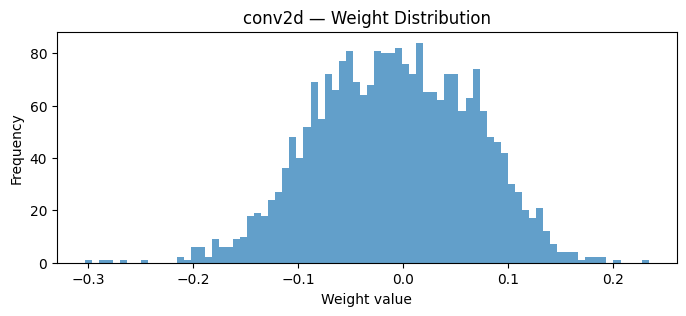

[ok]   conv2d                bias  min=-0.057268 max=0.097612


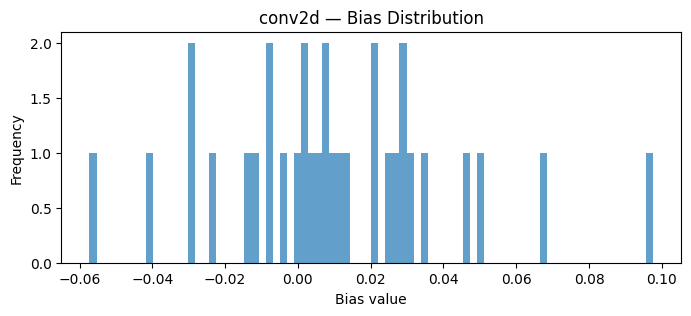

[ok]   conv2d_1             weight min=-0.486778 max=0.382551


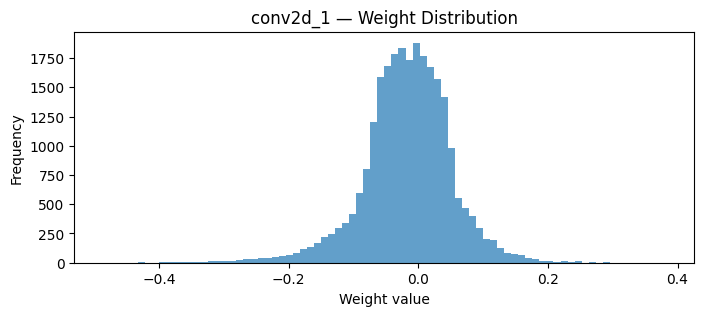

[ok]   conv2d_1              bias  min=-0.070180 max=0.095580


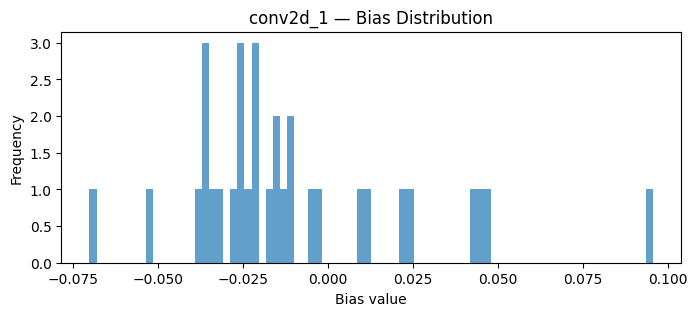

[skip] max_pooling2d        (no trainable weights)
[ok]   conv2d_2             weight min=-0.692378 max=0.324826


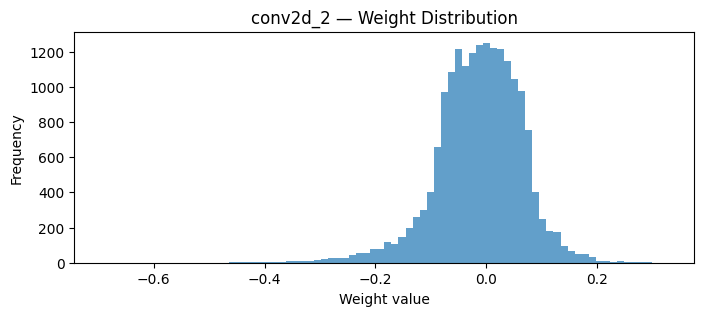

[ok]   conv2d_2              bias  min=-0.209900 max=0.152339


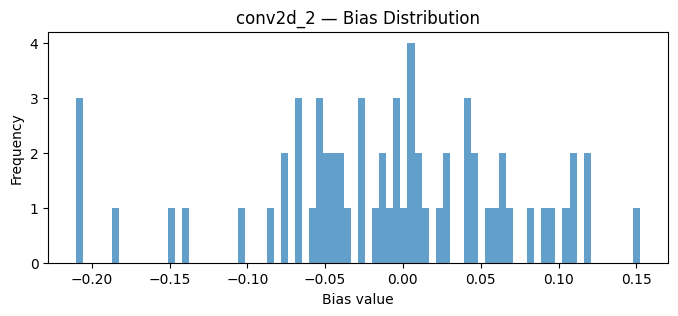

[ok]   conv2d_3             weight min=-0.541547 max=0.362909


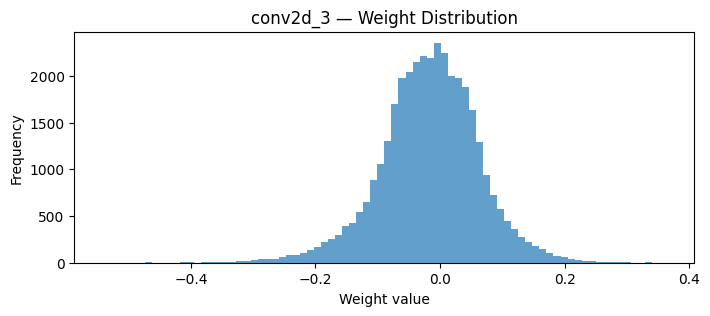

[ok]   conv2d_3              bias  min=-0.295808 max=0.102229


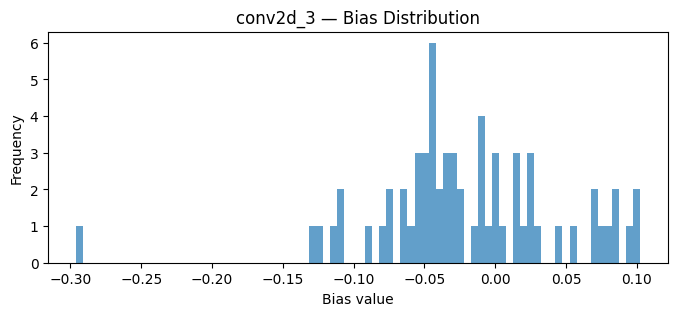

[skip] max_pooling2d_1      (no trainable weights)
[ok]   conv2d_4             weight min=-0.536679 max=0.362402


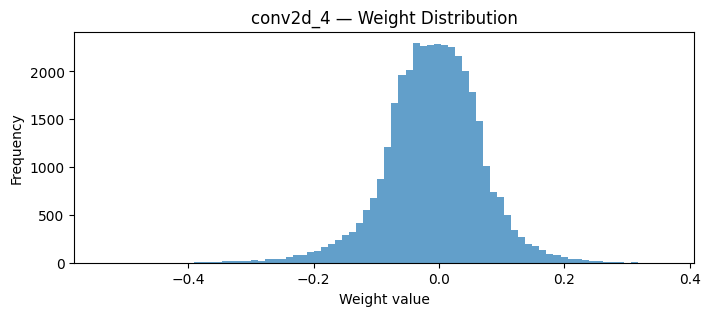

[ok]   conv2d_4              bias  min=-0.317999 max=0.180665


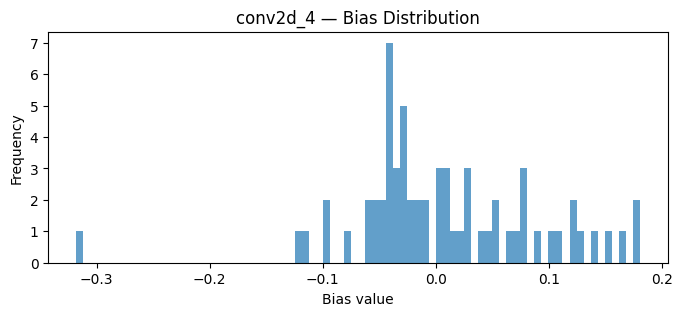

[ok]   conv2d_5             weight min=-0.510655 max=0.468192


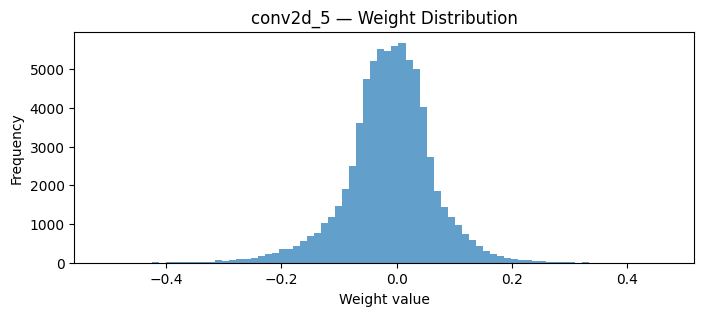

[ok]   conv2d_5              bias  min=-0.136140 max=0.212835


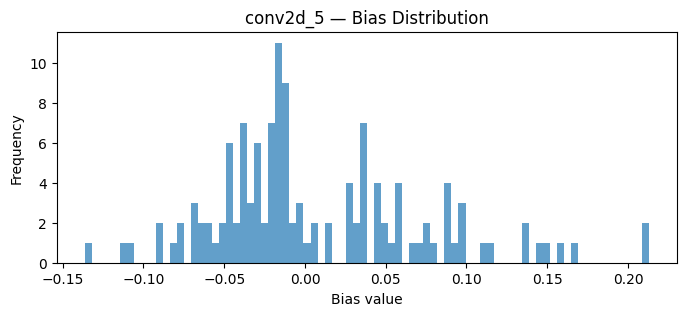

[skip] max_pooling2d_2      (no trainable weights)
[skip] flatten              (no trainable weights)
[ok]   dense                weight min=-0.557585 max=0.512802


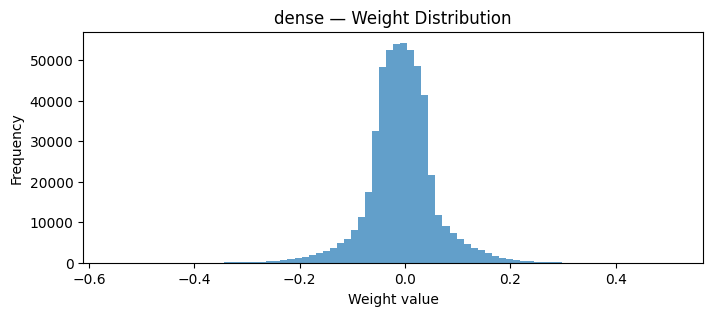

[ok]   dense                 bias  min=-0.179310 max=0.182238


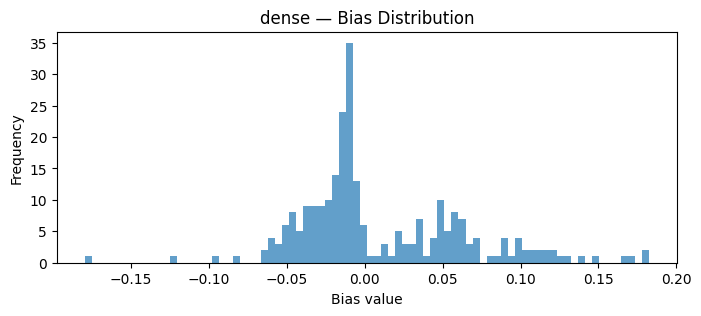

[ok]   dense_1              weight min=-1.324119 max=0.366575


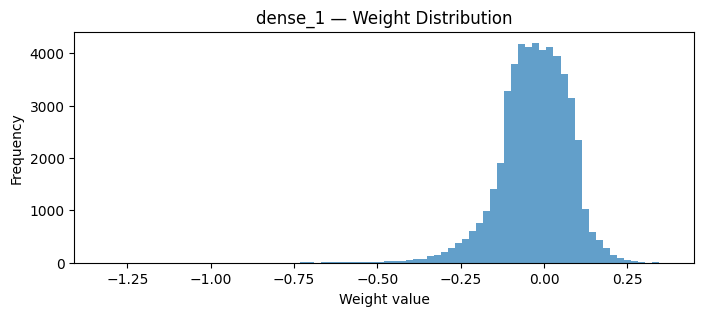

[ok]   dense_1               bias  min=-0.239749 max=0.163579


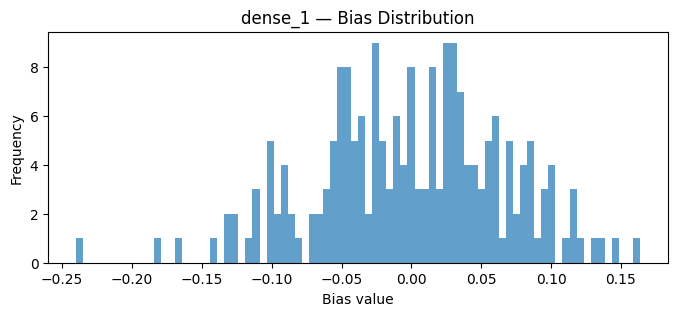

[{'layer': 'conv2d',
  'max': 0.23425443470478058,
  'min': -0.30287936329841614,
  'param': 'weight'},
 {'layer': 'conv2d',
  'max': 0.0976124033331871,
  'min': -0.05726848915219307,
  'param': 'bias'},
 {'layer': 'conv2d_1',
  'max': 0.3825509250164032,
  'min': -0.48677802085876465,
  'param': 'weight'},
 {'layer': 'conv2d_1',
  'max': 0.0955795869231224,
  'min': -0.07017958909273148,
  'param': 'bias'},
 {'layer': 'conv2d_2',
  'max': 0.3248261511325836,
  'min': -0.6923781633377075,
  'param': 'weight'},
 {'layer': 'conv2d_2',
  'max': 0.1523394137620926,
  'min': -0.20990024507045746,
  'param': 'bias'},
 {'layer': 'conv2d_3',
  'max': 0.36290860176086426,
  'min': -0.5415472388267517,
  'param': 'weight'},
 {'layer': 'conv2d_3',
  'max': 0.10222853720188141,
  'min': -0.2958078682422638,
  'param': 'bias'},
 {'layer': 'conv2d_4',
  'max': 0.3624016344547272,
  'min': -0.5366791486740112,
  'param': 'weight'},
 {'layer': 'conv2d_4',
  'max': 0.1806652545928955,
  'min': -0.3179

In [15]:
summaries = analyze_weights_biases_keras(
    model,
    bins=80,
    show_plots=True,          # set False if we only want files
    save_dir="reports/hists", # optional: saves images
    verbose=True              # prints per-layer min/max
)

from pprint import pprint
pprint(summaries)  


In [16]:
BYTES_FP32 = 4.0
BYTES_INT8 = 1.0
BYTES_INT2 = 0.25  # 2 bits = 0.25 bytes (ignore alignment for Phase I estimate)

def count_params(model):
    total_w, total_b = 0, 0
    per_layer = []
    for l in model.layers:
        wts = l.get_weights()
        if not wts: 
            continue
        W = wts[0] if len(wts) >= 1 else None
        B = wts[1] if len(wts) >= 2 else None
        nw = int(np.prod(W.shape)) if W is not None else 0
        nb = int(np.prod(B.shape)) if B is not None else 0
        total_w += nw
        total_b += nb
        per_layer.append({"name": l.name, "weights": nw, "biases": nb})
    return per_layer, total_w, total_b, total_w + total_b

per_layer, W, B, T = count_params(model)

def kb(x_bytes):  # Phase I states “1000 KB” constraint; using decimal KB
    return x_bytes / 1000.0

sizes = {
    "fp32_kb": kb((W+B)*BYTES_FP32),
    "int8_kb": kb((W+B)*BYTES_INT8),
    "int2_kb": kb((W+B)*BYTES_INT2),
    "counts": {"weights": W, "biases": B, "total": W+B},
    "per_layer": per_layer,
    "limit_kb": 1000.0
}

print(sizes)
# Decide max quantization level that would fit for our model under 1000 KB
fits = []
if sizes["fp32_kb"] <= sizes["limit_kb"]: fits.append("FP32")
if sizes["int8_kb"] <= sizes["limit_kb"]: fits.append("INT8")
if sizes["int2_kb"] <= sizes["limit_kb"]: fits.append("INT2")
print("Fits under 1000 KB:", fits if fits else "None (must compress more)")


{'fp32_kb': 3080.864, 'int8_kb': 770.216, 'int2_kb': 192.554, 'counts': {'weights': 769376, 'biases': 840, 'total': 770216}, 'per_layer': [{'name': 'conv2d', 'weights': 2400, 'biases': 32}, {'name': 'conv2d_1', 'weights': 25600, 'biases': 32}, {'name': 'conv2d_2', 'weights': 18432, 'biases': 64}, {'name': 'conv2d_3', 'weights': 36864, 'biases': 64}, {'name': 'conv2d_4', 'weights': 36864, 'biases': 64}, {'name': 'conv2d_5', 'weights': 73728, 'biases': 128}, {'name': 'dense', 'weights': 524288, 'biases': 256}, {'name': 'dense_1', 'weights': 51200, 'biases': 200}], 'limit_kb': 1000.0}
Fits under 1000 KB: ['INT8', 'INT2']


In [17]:


# 1) Show the dataset's element_spec (types/shapes without running it)
print("Element spec:", ds_train.element_spec)

# 2) Peek one element/batch to see real tensors and keys
for sample in ds_train.take(1):
    print("Raw sample type:", type(sample))
    print(sample)
    break


Element spec: {'id': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'metadata': {'label_name': TensorSpec(shape=(), dtype=tf.string, name=None)}}
Raw sample type: <class 'dict'>
{'id': <tf.Tensor: shape=(), dtype=string, numpy=b'n04328186'>, 'image': <tf.Tensor: shape=(64, 64, 3), dtype=uint8, numpy=
array([[[ 28,  21,   5],
        [ 19,   7,   0],
        [ 58,  40,  26],
        ...,
        [157, 128, 114],
        [152, 132, 125],
        [146, 131, 126]],

       [[ 42,  26,  11],
        [ 33,  15,   1],
        [ 33,   9,   0],
        ...,
        [158, 129, 115],
        [154, 134, 125],
        [149, 134, 127]],

       [[ 60,  31,  17],
        [ 54,  22,   9],
        [ 73,  37,  25],
        ...,
        [160, 131, 115],
        [155, 135, 124],
        [156, 139, 131]],

       ...,

       [[179, 139, 104],
        [169, 126,  91],
        [153

2025-11-04 14:54:08.896659: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [ ]:
# DONE IN THE NEXT CELL
# import tensorflow as tf

# def get_image_and_label(example):
#     return example['image'], example.get('label', None)
    
# def to_float01(example):
#     img, lbl = get_image_and_label(example)
#     # image is uint8 [0,255] -> float32 [0,1]
#     img = tf.cast(img, tf.float32) / 255.0
#     # already (64,64,3); ensure in [0,1]
#     img = tf.clip_by_value(img, 0.0, 1.0)
#     return img, lbl

# BATCH = 64

# def make_cal_ds(ds_train):
#     # ORDER: map -> take(1000) -> cache -> batch -> prefetch
#     return (ds_train
#             .map(to_float01, num_parallel_calls=tf.data.AUTOTUNE)
#             .take(1000)                  # then take 1k
#             .cache()                     # cache the mapped stream
#             .batch(BATCH)                 # batch after caching
#             .prefetch(tf.data.AUTOTUNE))                    

# # a fresh pass
# cal_ds = make_cal_ds(ds_train)

# # compute input mean 
# def compute_input_mean(dataset):
#     sm, cnt = 0.0, 0
#     for x, _ in dataset:                 # ok to iterate; since we can rebuild cal_ds later
#         sm += tf.reduce_sum(x).numpy()
#         cnt += tf.size(x).numpy()
#     return sm / max(1, cnt)

# input_mean = compute_input_mean(make_cal_ds(ds_train))  # build a fresh one for this pass
# print("Input mean:", input_mean)

Input mean: 0.44154735056559247


2025-10-19 12:03:21.565211: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-10-19 12:03:21.569054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
import tensorflow as tf
import numpy as np
import json
from tensorflow.keras.layers import Conv2D, Dense


def get_image_and_label(example):
    return example['image'], example.get('label', None)
    
def to_float01(example):
    img, lbl = get_image_and_label(example)
    # image is uint8 [0,255] -> float32 [0,1]
    img = tf.cast(img, tf.float32) / 255.0
    # already (64,64,3); ensure in [0,1]
    img = tf.clip_by_value(img, 0.0, 1.0)
    return img, lbl

BATCH = 64

def make_cal_ds(ds_train):
    # ORDER: map -> take(1000) -> cache -> batch -> prefetch
    return (ds_train
            .map(to_float01, num_parallel_calls=tf.data.AUTOTUNE)
            .take(1000)                  # then take 1k
            .cache()                     # cache the mapped stream
            .batch(BATCH)                 # batch after caching
            .prefetch(tf.data.AUTOTUNE))        

# --- 0) Use existing make_cal_ds(ds_train) from earlier ---
cal_ds = make_cal_ds(ds_train)  # map -> take(1000) -> cache -> batch -> prefetch

# --- 1) Clone model with activations stripped (pre-activation taps) ---
def strip_activations(layer):
    cfg = layer.get_config()
    if isinstance(layer, (Conv2D, Dense)) and cfg.get('activation'):
        cfg['activation'] = None
    return layer.__class__.from_config(cfg)

preact_model = tf.keras.models.clone_model(model, clone_function=strip_activations)
preact_model.set_weights(model.get_weights())

# --- 2) Build a probe by REPLAYING layers on a new Input (no stale tensors) ---
INPUT_SHAPE = (64, 64, 3)
x = tf.keras.Input(shape=INPUT_SHAPE)

y = x
probe_outputs = []
probe_layer_names = []

for lyr in preact_model.layers:
    # Skip the auto-added InputLayer if present
    if isinstance(lyr, tf.keras.layers.InputLayer):
        continue
    y = lyr(y)  # replay the layer on the current tensor
    if isinstance(lyr, (Conv2D, Dense)):
        probe_outputs.append(y)          # PRE-activation because we stripped activations
        probe_layer_names.append(lyr.name)

probe = tf.keras.Model(inputs=x, outputs=probe_outputs)

# --- 3) Collect per-layer {min, max, mean} over 1k images ---
mins   = {n:  np.inf for n in probe_layer_names}
maxs   = {n: -np.inf for n in probe_layer_names}
sums   = {n:  0.0    for n in probe_layer_names}
counts = {n:  0      for n in probe_layer_names}

# Use a fresh cal_ds iterator to avoid partial-cache warnings
for xb, _ in make_cal_ds(ds_train):
    outs = probe(xb, training=False)  # list of tensors aligned with probe_layer_names
    if not isinstance(outs, (list, tuple)):
        outs = [outs]
    for name, t in zip(probe_layer_names, outs):
        t = tf.cast(t, tf.float32)
        mins[name]   = min(mins[name], float(tf.reduce_min(t).numpy()))
        maxs[name]   = max(maxs[name], float(tf.reduce_max(t).numpy()))
        sums[name]  += float(tf.reduce_sum(t).numpy())
        counts[name] += int(tf.size(t).numpy())

act_stats = {
    n: {
        "min": float(mins[n]),
        "max": float(maxs[n]),
        "mean": float(sums[n] / max(1, counts[n]))
    }
    for n in probe_layer_names
}

# --- 4) Compute activation scales S_i and zero-points z_i (activations only) ---
def compute_activation_scales(act_stats, input_mean):
    out = {}
    for lname, s in act_stats.items():
        centered_max = max(abs(s["mean"] - s["min"]), abs(s["max"] - s["mean"]))
        Si = 127.0 / max(centered_max, 1e-12)
        zi = int(np.round(-s["mean"] * Si))
        out[lname] = {"min": s["min"], "max": s["max"], "mean": s["mean"], "Si": float(Si), "zi": int(zi)}
    # First-layer input (images are [0,1])
    centered_max_input = max(input_mean - 0.0, 1.0 - input_mean)
    Si_input = 127.0 / max(centered_max_input, 1e-12)
    zi_input = int(np.round(-input_mean * Si_input))
    out["_input"] = {"mean": float(input_mean), "Si": float(Si_input), "zi": int(zi_input)}
    return out

# compute input mean robustly on a fresh iterator
def compute_input_mean(ds):
    sm, cnt = 0.0, 0
    for xb, _ in make_cal_ds(ds):
        sm += tf.reduce_sum(xb).numpy()
        cnt += tf.size(xb).numpy()
    return sm / max(1, cnt)

input_mean = compute_input_mean(ds_train)
layer_calib = compute_activation_scales(act_stats, input_mean)

# --- 5) Sanity checks + save calibrations ---
for name, rec in layer_calib.items():
    if name == "_input": 
        continue
    assert rec["max"] > rec["min"], f"{name}: non-positive range (likely tapped post-ReLU by mistake)"
    assert -128 <= rec["zi"] <= 127, f"{name}: z_i out of int8 range; we will need to inspect stats/Si"

with open("calibration_stats.json", "w") as f:
    json.dump(layer_calib, f, indent=2)

print(f"Activations collected for {len(probe_layer_names)} layers")
print("Input mean:", input_mean)
print("Output written to calibration_stats.json")


2025-11-04 14:54:17.362162: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-11-04 14:54:17.486240: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-04 14:54:17.558646: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.

Activations collected for 8 layers
Input mean: 0.4462892735799154
Output written to calibration_stats.json


## To Int 4

In [22]:
import tensorflow as tf
import numpy as np
import json
from tensorflow.keras.layers import Conv2D, Dense


def get_image_and_label(example):
    return example['image'], example.get('label', None)
    
def to_float01(example):
    img, lbl = get_image_and_label(example)
    # image is uint8 [0,255] -> float32 [0,1]
    img = tf.cast(img, tf.float32) / 255.0
    # already (64,64,3); ensure in [0,1]
    img = tf.clip_by_value(img, 0.0, 1.0)
    return img, lbl

BATCH = 64

def make_cal_ds(ds_train):
    # ORDER: map -> take(1000) -> cache -> batch -> prefetch
    return (ds_train
            .map(to_float01, num_parallel_calls=tf.data.AUTOTUNE)
            .take(1000)                  # then take 1k
            .cache()                     # cache the mapped stream
            .batch(BATCH)                 # batch after caching
            .prefetch(tf.data.AUTOTUNE))        

# --- 0) Use existing make_cal_ds(ds_train) from earlier ---
cal_ds = make_cal_ds(ds_train)  # map -> take(1000) -> cache -> batch -> prefetch

# --- 1) Clone model with activations stripped (pre-activation taps) ---
def strip_activations(layer):
    cfg = layer.get_config()
    if isinstance(layer, (Conv2D, Dense)) and cfg.get('activation'):
        cfg['activation'] = None
    return layer.__class__.from_config(cfg)

preact_model = tf.keras.models.clone_model(model, clone_function=strip_activations)
preact_model.set_weights(model.get_weights())

# --- 2) Build a probe by REPLAYING layers on a new Input (no stale tensors) ---
INPUT_SHAPE = (64, 64, 3)
x = tf.keras.Input(shape=INPUT_SHAPE)

y = x
probe_outputs = []
probe_layer_names = []

for lyr in preact_model.layers:
    # Skip the auto-added InputLayer if present
    if isinstance(lyr, tf.keras.layers.InputLayer):
        continue
    y = lyr(y)  # replay the layer on the current tensor
    if isinstance(lyr, (Conv2D, Dense)):
        probe_outputs.append(y)          # PRE-activation because we stripped activations
        probe_layer_names.append(lyr.name)

probe = tf.keras.Model(inputs=x, outputs=probe_outputs)

# --- 3) Collect per-layer {min, max, mean} over 1k images ---
mins   = {n:  np.inf for n in probe_layer_names}
maxs   = {n: -np.inf for n in probe_layer_names}
sums   = {n:  0.0    for n in probe_layer_names}
counts = {n:  0      for n in probe_layer_names}

# Use a fresh cal_ds iterator to avoid partial-cache warnings
for xb, _ in make_cal_ds(ds_train):
    outs = probe(xb, training=False)  # list of tensors aligned with probe_layer_names
    if not isinstance(outs, (list, tuple)):
        outs = [outs]
    for name, t in zip(probe_layer_names, outs):
        t = tf.cast(t, tf.float32)
        mins[name]   = min(mins[name], float(tf.reduce_min(t).numpy()))
        maxs[name]   = max(maxs[name], float(tf.reduce_max(t).numpy()))
        sums[name]  += float(tf.reduce_sum(t).numpy())
        counts[name] += int(tf.size(t).numpy())

act_stats = {
    n: {
        "min": float(mins[n]),
        "max": float(maxs[n]),
        "mean": float(sums[n] / max(1, counts[n]))
    }
    for n in probe_layer_names
}

# --- 4) Compute activation scales S_i and zero-points z_i (activations only) ---
def compute_activation_scales(act_stats, input_mean):
    qmax = 7
    qmin = -8
    out = {}
    for lname, s in act_stats.items():
        centered_max = max(abs(s["mean"] - s["min"]), abs(s["max"] - s["mean"]))
        Si = float(qmax) / max(centered_max, 1e-12)
        zi = int(np.round(-s["mean"] * Si))
        zi = int(np.clip(zi, qmin, qmax))
        out[lname] = {"min": s["min"], "max": s["max"], "mean": s["mean"], "Si": float(Si), "zi": int(zi)}
    # First-layer input (images are [0,1])
    centered_max_input = max(input_mean - 0.0, 1.0 - input_mean)
    Si_input = float(qmax) / max(centered_max_input, 1e-12)
    zi_input = int(np.round(-input_mean * Si_input))
    zi_input = int(np.clip(zi_input, qmin, qmax))
    out["_input"] = {"mean": float(input_mean), "Si": float(Si_input), "zi": int(zi_input)}
    return out
# compute input mean robustly on a fresh iterator
def compute_input_mean(ds):
    sm, cnt = 0.0, 0
    for xb, _ in make_cal_ds(ds):
        sm += tf.reduce_sum(xb).numpy()
        cnt += tf.size(xb).numpy()
    return sm / max(1, cnt)

input_mean = compute_input_mean(ds_train)
layer_calib = compute_activation_scales(act_stats, input_mean)

# --- 5) Sanity checks + save calibrations ---
for name, rec in layer_calib.items():
    if name == "_input": 
        continue
    assert rec["max"] > rec["min"], f"{name}: non-positive range (likely tapped post-ReLU by mistake)"
   # assert -8 <= rec["zi"] <= 7, f"{name}: z_i out of int8 range; we will need to inspect stats/Si"

with open("calibration_stats_int4.json", "w") as f:
    json.dump(layer_calib, f, indent=2)

print(f"Activations collected for {len(probe_layer_names)} layers")
print("Input mean:", input_mean)
print("Output written to calibration_stats_int4.json")


Activations collected for 8 layers
Input mean: 0.44245070139567055
Output written to calibration_stats_int4.json


2025-11-04 15:06:29.287479: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-11-04 15:06:29.387825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-04 15:06:29.473528: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.

Label: [b'black stork, Ciconia nigra'] (class index: [115] - id: [b'n02002724'])


2025-10-18 14:19:58.565788: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
I0000 00:00:1760815198.694803 3669816 service.cc:145] XLA service 0x7f5840007b10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760815198.694835 3669816 service.cc:153]   StreamExecutor device (0): NVIDIA A40-8Q, Compute Capability 8.6
2025-10-18 14:19:58.700977: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-18 14:19:58.767860: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuD

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
Best Guess [class index]: ['black stork', 'Ciconia nigra'] [115]
Best Guess Confidence (percent / 1.0): [0.24593282]
Top 15 Guesses (class index): ["['black stork', 'Ciconia nigra'] [115]", "['syringe'] [162]", "['remote control', 'remote'] [54]", "['dumbbell'] [154]", "['bikini', 'two-piece'] [142]", "['scorpion'] [125]", "['goose'] [67]", "['stopwatch', 'stop watch'] [137]", "['reel'] [1]", "['oboe', 'hautboy', 'hautbois'] [20]", "['pole'] [176]", "['cockroach', 'roach'] [48]", "['snorkel'] [111]", "['magnetic compass'] [191]", "['slug'] [100]"]
Top 15 Guesses Confidence (percent / 1.0): [[0.24593282 0.1766632  0.05454575 0.04001854 0.03431227 0.02799901
  0.02453601 0.0241977  0.02324558 0.02140605 0.0205867  0.02032521
  0.01958575 0.0142417  0.01374249]]


I0000 00:00:1760815199.233401 3669816 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-10-18 14:19:59.263319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


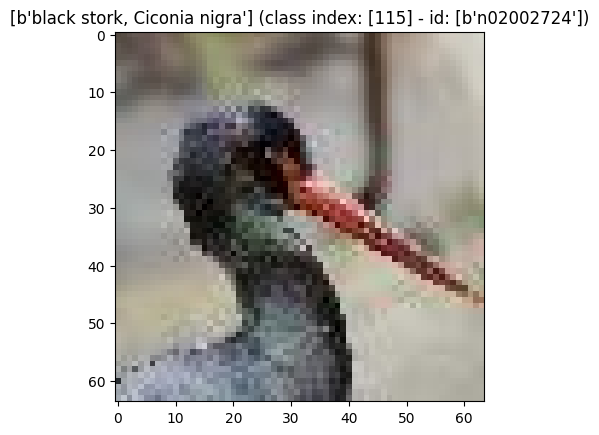

In [ ]:
# Running infrence on our model
# We can run an infrence of our model by doing the following (we are doing batches of 1 here)
for example in ds_train.batch(1).take(1):
    img_info(example)

    # Make a prediction
    pred = model.predict(tf.cast(example["image"], tf.float32)/255.0)
    # print(f'Raw 200 Class Weighted Prediction:\n{pred}') # Uncomment to see the raw prediction

    # What is out best guess?
    best_guess = tf.math.argmax(pred, axis=1).numpy() # Our output is 200 weighted value, we want the most likely
    print(f'Best Guess [class index]: {class_names[best_guess[0]]} [{best_guess[0]}]')
    print(f'Best Guess Confidence (percent / 1.0): {pred[0][best_guess]}')

    # What are our top 15 guesses?
    top_15 = tf.math.top_k(pred, k=15)
    print(f'Top 15 Guesses (class index): {[f"{class_names[idx]} [{idx}]" for idx in top_15.indices[0]]}')
    print(f'Top 15 Guesses Confidence (percent / 1.0): {top_15.values}')

In [ ]:
# TODO: Print and visualize three inputs from the validation set
#     : Print the stroage data type
#     : Print and note the dimensions of each image
#     : Print the memory required to store each image

# Sample Images
sample_imgs = []
for index, img_data in enumerate(ds_val):
    sample_imgs.append(img_data)
    image, label, id, label_name = img_data["image"], img_data["label"], img_data["id"], img_data["metadata"]['label_name']

    print(f'\n--- Image {index} ---')
    print(f'Storage Data Type: {image.dtype}')
    print(f'Image Dimensions: {image.shape}')
    print(f'Memory Required to Store Image: {image.numpy().nbytes} bytes')
    # TODO: Your Code Here
    # See example usage: https://github.com/duweisu/tiny-imagenet-tfds


--- Image 0 ---
Storage Data Type: <dtype: 'uint8'>
Image Dimensions: (64, 64, 3)
Memory Required to Store Image: 12288 bytes

--- Image 1 ---
Storage Data Type: <dtype: 'uint8'>
Image Dimensions: (64, 64, 3)
Memory Required to Store Image: 12288 bytes

--- Image 2 ---
Storage Data Type: <dtype: 'uint8'>
Image Dimensions: (64, 64, 3)
Memory Required to Store Image: 12288 bytes


2025-10-11 19:59:42.852928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# Create a summary table for the sample images
table_data = []

for index, img_data in enumerate(sample_imgs):
    img_cast = tf.cast(img_data["image"], tf.float32)
    pred = model.predict(img_cast[tf.newaxis, ...]/255.0, verbose=0)

    best_guess = tf.math.argmax(pred, axis=1).numpy()
    table_data.append([
        class_names[best_guess[0]],
        float(pred[0][best_guess[0]]),
        img_class(img_data)
    ])

# Display the results in a nice table
results_df = pd.DataFrame(table_data, columns=["Best Guess", "Confidence", "Actual Class"])
print("Summary of Sample Image Predictions:")
display(results_df)

Summary of Sample Image Predictions:


,Best Guess,Confidence,Actual Class
0,['abacus'],0.804917,b'abacus' (class index: 63 - id: b'n02666196')
1,"[""potter's wheel""]",0.212214,"b'meat loaf, meatloaf' (class index: 192 - id:..."
2,['moving van'],0.110711,b'barbershop' (class index: 145 - id: b'n02791...


In [ ]:
# TODO: Calculate the Top-1, Top-5, and Top-10 Accuracy of the validation dataset
total = acc_top1 = acc_top5 = acc_top10 = 0

# Perform inference in batches to speed up the process since I am
# a very impatient person.
for img in ds_val.batch(1000):
    # Get the actual number of images in the batch
    # since the last batch may be smaller than the batch size
    total += tf.shape(img["image"])[0]
    pred = model.predict(tf.cast(img["image"], tf.float32)/255.0, verbose=0)
    actual = img["label"].numpy()

    # pred contains the prediction for the entire batch,
    # so we need to return the top 1, 5, and 10 for each image in the batch
    top_1 = np.argmax(pred, axis=1)
    top_5 = np.argsort(pred, axis=1)[:,-5:]
    top_10 = np.argsort(pred, axis=1)[:,-10:]

    # Similar to the above, using the builtin python function,
    # we are able to perform the calculation for the entire batch
    acc_top1 += sum(top_1 == actual)
    acc_top5 += sum(actual[i] in top_5[i] for i in range(len(actual)))
    acc_top10 += sum(actual[i] in top_10[i] for i in range(len(actual)))

print(f'Top-1 Accuracy: {acc_top1/total*100:.2f}%')
print(f'Top-5 Accuracy: {acc_top5/total*100:.2f}%')
print(f'Top-10 Accuracy: {acc_top10/total*100:.2f}%')


I0000 00:00:1760893129.677577 3854049 service.cc:145] XLA service 0x7fafb80040c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760893129.677614 3854049 service.cc:153]   StreamExecutor device (0): NVIDIA A40-8Q, Compute Capability 8.6
2025-10-19 11:58:49.683753: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1760893130.923902 3854049 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Top-1 Accuracy: 24.27%
Top-5 Accuracy: 49.41%
Top-10 Accuracy: 61.74%


2025-10-19 11:58:53.241114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# TODO: Print all of the possible classes of the dataset

for str in class_names:
    print(str)

['Egyptian cat']
['reel']
['volleyball']
['rocking chair', 'rocker']
['lemon']
['bullfrog', 'Rana catesbeiana']
['basketball']
['cliff', 'drop', 'drop-off']
['espresso']
['plunger', "plumber's helper"]
['parking meter']
['German shepherd', 'German shepherd dog', 'German police dog', 'alsatian']
['dining table', 'board']
['monarch', 'monarch butterfly', 'milkweed butterfly', 'Danaus plexippus']
['brown bear', 'bruin', 'Ursus arctos']
['school bus']
['pizza', 'pizza pie']
['guinea pig', 'Cavia cobaya']
['umbrella']
['organ', 'pipe organ']
['oboe', 'hautboy', 'hautbois']
['maypole']
['goldfish', 'Carassius auratus']
['potpie']
['hourglass']
['seashore', 'coast', 'seacoast', 'sea-coast']
['computer keyboard', 'keypad']
['Arabian camel', 'dromedary', 'Camelus dromedarius']
['ice cream', 'icecream']
['nail']
['space heater']
['cardigan']
['baboon']
['snail']
['coral reef']
['albatross', 'mollymawk']
['spider web', "spider's web"]
['sea cucumber', 'holothurian']
['backpack', 'back pack', 'kna

## Model Exploration

Model diagram saved as 'model.png'


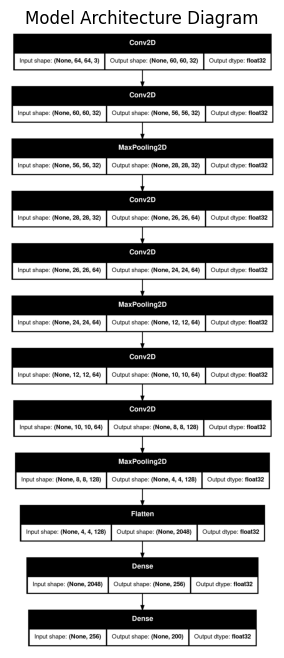

In [ ]:
# TODO: Visualize the model in Netron (https://netron.app/) and include an image here.

# Option 1: Try to use pydot (requires Graphviz to be installed)
try:
    tf.keras.utils.plot_model(model, "model.png", show_shapes=True, show_dtype=True, expand_nested=True)
    print("Model diagram saved as 'model.png'")

    # Display the image
    from PIL import Image
    import matplotlib.pyplot as plt

    img = Image.open('model.png')
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Model Architecture Diagram')
    plt.show()

except Exception as e:
    print(f"Could not generate model diagram with pydot: {e}")
    print("\nAlternative: Displaying model summary and layer details...")

    # Option 2: Alternative visualization using model summary
    print("\n" + "="*60)
    print("MODEL ARCHITECTURE SUMMARY")
    print("="*60)

    model.summary()

    print("\n" + "="*60)
    print("DETAILED LAYER INFORMATION")
    print("="*60)

    for i, layer in enumerate(model.layers):
        print(f"\nLayer {i+1}: {layer.name}")
        print(f"  Type: {type(layer).__name__}")
        print(f"  Input shape: {layer.input_shape if hasattr(layer, 'input_shape') else 'N/A'}")
        print(f"  Output shape: {layer.output_shape if hasattr(layer, 'output_shape') else 'N/A'}")
        if hasattr(layer, 'filters'):
            print(f"  Filters: {layer.filters}")
        if hasattr(layer, 'kernel_size'):
            print(f"  Kernel size: {layer.kernel_size}")
        if hasattr(layer, 'activation'):
            print(f"  Activation: {layer.activation.__name__ if callable(layer.activation) else layer.activation}")
        param_count = layer.count_params()
        print(f"  Parameters: {param_count:,}")

    # Option 3: Save model as JSON for external visualization
    model_json = model.to_json()
    with open('model_architecture.json', 'w') as f:
        f.write(model_json)
    print(f"\nModel architecture saved as 'model_architecture.json'")
    print("You can load this file into Netron (https://netron.app/) for visualization")

    # Option 4: Create a simple text-based architecture diagram
    print("\n" + "="*60)
    print("TEXT-BASED ARCHITECTURE DIAGRAM")
    print("="*60)

    print("INPUT: (64, 64, 3)")
    print("     |")

    for i, layer in enumerate(model.layers):
        if 'conv2d' in layer.name.lower():
            print(f"  CONV2D-{i+1}: {layer.filters} filters, {layer.kernel_size} kernel")
        elif 'max_pooling2d' in layer.name.lower():
            print(f"  MAXPOOL-{i+1}: {layer.pool_size} pool size")
        elif 'flatten' in layer.name.lower():
            print(f"  FLATTEN-{i+1}")
        elif 'dense' in layer.name.lower():
            print(f"  DENSE-{i+1}: {layer.units} units")
        else:
            print(f"  {layer.name.upper()}-{i+1}")

        if i < len(model.layers) - 1:
            print("     |")

    print("     |")
    print("OUTPUT: (200,) - Classification probabilities")

Layer Name: conv2d
Weight Data Type: float32
Weight Dimensions: (5, 5, 3, 32)
Weight Memory Size: 9600 bytes

Layer Name: conv2d_5
Weight Data Type: float32
Weight Dimensions: (3, 3, 64, 128)
Weight Memory Size: 294912 bytes



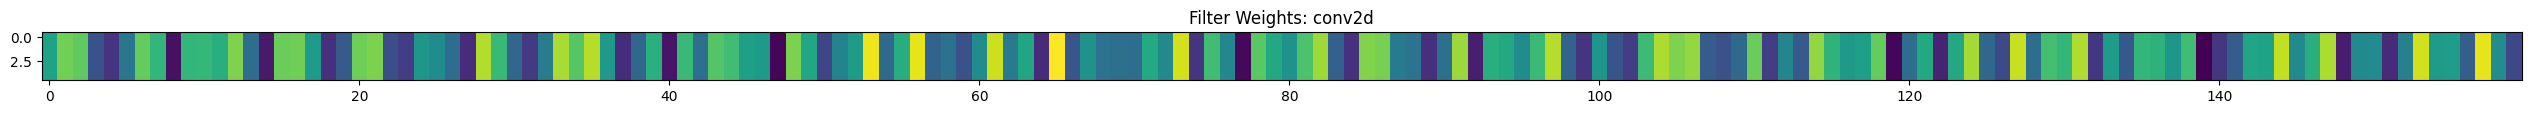

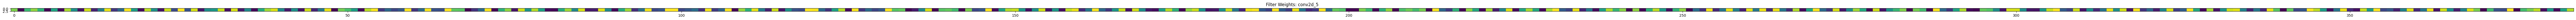

In [ ]:
# We can view the layer weights. Here we consider them as images of feature filters applied to intermediate feature map images.
# TODO: Visualize the 2 convolutional layers filter sets (weights) (one at the beginning and one at the end)

layer_names = [layer.name for layer in model.layers]

# Get only first and last conv layers
conv_layers = [(name, fm) for name, fm in zip(layer_names, model.layers) if 'conv' in name]
layers_to_show = [conv_layers[0], conv_layers[-1]]  # first and last

for layer_name, layer in layers_to_show:
    if not layer.weights:
        continue
    # Get the weights of the layer
    weights = layer.get_weights()[0]

    k = weights.shape[-1]
    # Create a wider figure to show all filters in one row
    size = weights.shape[1]
    scale = (20. / k)
    image_belt = np.zeros((size, size*k), dtype='uint8')

    for i in range(k):
        if len(weights.shape) == 4:  # Conv2D weights
            feature_image = weights[0, :, 0, i]
        else:
            continue

        # Normalize the image
        feature_image -= feature_image.mean()
        feature_image /= feature_image.std()
        feature_image *= 64
        feature_image += 128
        feature_image = np.clip(feature_image, 0, 255).astype('uint8')
        image_belt[:, i*size : (i+1) * size] = feature_image

    plt.figure(figsize=(k, scale))
    plt.title(f'Filter Weights: {layer_name}')
    plt.grid(False)
    plt.imshow(image_belt, aspect='auto')
    print(f'Layer Name: {layer_name}')
    print(f'Weight Data Type: {weights.dtype}')
    print(f'Weight Dimensions: {weights.shape}')
    print(f'Weight Memory Size: {weights.nbytes} bytes')
    print('')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
Layer Name: conv2d
Layer Data Type: float32
Layer Dimensions: (1, 60, 60, 32)
Layer Memory Size: 460800 bytes

Layer Name: conv2d_5
Layer Data Type: float32
Layer Dimensions: (1, 8, 8, 128)
Layer Memory Size: 32768 bytes



/tmp/ipykernel_2377980/3167234515.py:32: RuntimeWarning: invalid value encountered in divide
  feature_image /= feature_image.std()
/tmp/ipykernel_2377980/3167234515.py:35: RuntimeWarning: invalid value encountered in cast
  feature_image = np.clip(feature_image, 0, 255).astype('uint8')


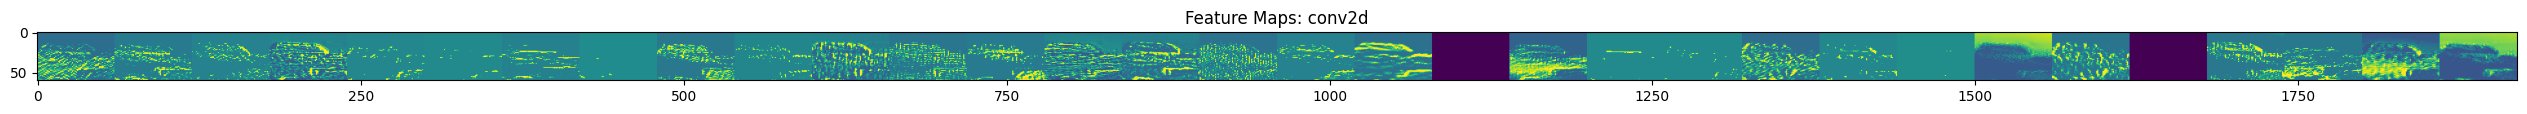

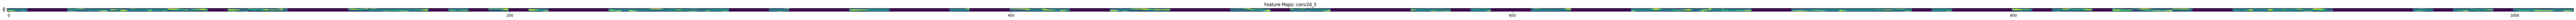

In [ ]:
# We can view the layer outputs as well. Here we consider them as images of the spatial location of features.
# TODO: Visualize the 2 convolutional layers outputs (intermediate feature maps) (one at the beginning and one at the end)

layer_names = [layer.name for layer in model.layers]
layer_outputs = [layer.output for layer in model.layers]

image_input = sample_imgs[0]["image"].numpy()
image_input = image_input.reshape((1,) + image_input.shape)

# Normalize the input
image_input = image_input.astype(np.float32) / 255.0

feature_maps_model = tf.keras.models.Model(inputs=model.inputs, outputs=layer_outputs)
feature_maps = feature_maps_model.predict(image_input)

# Get only first and last conv layers
conv_layers = [(name, fm) for name, fm in zip(layer_names, feature_maps) if 'conv' in name]
layers_to_show = [conv_layers[0], conv_layers[-1]]  # first and last

for layer_name, feature_map in layers_to_show:
    if len(feature_map.shape) == 4:
        k = feature_map.shape[-1]
        # Create a wider figure to show all filters in one row
        size = feature_map.shape[1]
        scale = (20. / k)
        image_belt = np.zeros((size, size*k), dtype='uint8')

        for i in range(k):
            feature_image = feature_map[0, :, :, i]
            # Normalize the image
            feature_image -= feature_image.mean()
            feature_image /= feature_image.std()
            feature_image *= 64
            feature_image += 128
            feature_image = np.clip(feature_image, 0, 255).astype('uint8')
            image_belt[:, i*size : (i+1) * size] = feature_image

        plt.figure(figsize=(k, scale))
        plt.title(f'Feature Maps: {layer_name}')
        plt.grid(False)
        plt.imshow(image_belt, aspect='auto')
        print(f'Layer Name: {layer_name}')
        print(f'Layer Data Type: {feature_map.dtype}')
        print(f'Layer Dimensions: {feature_map.shape}')
        print(f'Layer Memory Size: {feature_map.nbytes} bytes')
        print('')

In [ ]:
# TODO: Export the filters/weights so we can use them later
# Make a directory for our image data
model_dir = os.path.abspath('model_data')
pathlib.Path(model_dir).mkdir(exist_ok=True)


# Export each image
conv_index = dense_index = 1 # layer index starts from one
for layer_idx, layer in enumerate(model.layers):
    if re.match(r'(conv|dense)', layer.name):
        weight_file_name = os.path.join(model_dir, f'{layer.name}_weights.bin')
        bias_file_name = os.path.join(model_dir, f'{layer.name}_bias.bin')
    else: continue

    assert layer.weights[0].name.endswith('kernel')
    assert layer.weights[1].name.endswith('bias')



    # TODO: Your Code Here
    weights = layer.weights[0].numpy().flatten()
    biases = layer.weights[1].numpy().flatten()
    weights.tofile(weight_file_name)
    biases.tofile(bias_file_name)
    print(f'Exported weights to {weight_file_name} and biases to {bias_file_name}')

Exported weights to /home/bbista22/Desktop/lab1/model_data/conv2d_weights.bin and biases to /home/bbista22/Desktop/lab1/model_data/conv2d_bias.bin
Exported weights to /home/bbista22/Desktop/lab1/model_data/conv2d_1_weights.bin and biases to /home/bbista22/Desktop/lab1/model_data/conv2d_1_bias.bin
Exported weights to /home/bbista22/Desktop/lab1/model_data/conv2d_2_weights.bin and biases to /home/bbista22/Desktop/lab1/model_data/conv2d_2_bias.bin
Exported weights to /home/bbista22/Desktop/lab1/model_data/conv2d_3_weights.bin and biases to /home/bbista22/Desktop/lab1/model_data/conv2d_3_bias.bin
Exported weights to /home/bbista22/Desktop/lab1/model_data/conv2d_4_weights.bin and biases to /home/bbista22/Desktop/lab1/model_data/conv2d_4_bias.bin
Exported weights to /home/bbista22/Desktop/lab1/model_data/conv2d_5_weights.bin and biases to /home/bbista22/Desktop/lab1/model_data/conv2d_5_bias.bin
Exported weights to /home/bbista22/Desktop/lab1/model_data/dense_weights.bin and biases to /home/b

In [ ]:
# TODO: Export the intermediate layer outputs for each of the input for all of the layers
img_dir = os.path.abspath('img_data')
pathlib.Path(img_dir).mkdir(exist_ok=True)

for img_idx, img in enumerate(sample_imgs):
    file_dir = os.path.join(img_dir, f'test_input_{img_idx}')
    pathlib.Path(file_dir).mkdir(exist_ok=True)

    # TODO: Your Code Here
    img_batch = tf.expand_dims(img["image"], 0)  # Add batch dimension
    normalized_img = tf.cast(img_batch, tf.float32)/255.0

    # Get intermediate outputs by creating a model that outputs all layer outputs
    layer_outputs = []
    x = normalized_img

    # Process through each layer and collect outputs
    for layer_idx, layer in enumerate(model.layers):
        x = layer(x)
        layer_outputs.append(x)

        # Export this layer's output
        layer_name = layer.name
        output_file = os.path.join(file_dir, f'{layer_name}_output.bin')

        # Flatten and save the output
        flattened_output = x.numpy().flatten()
        flattened_output.astype(np.float32).tofile(output_file)
        print(f'Exported {layer_name} output to {output_file}')

Exported conv2d output to /home/bbista22/Desktop/lab1/img_data/test_input_0/conv2d_output.bin
Exported conv2d_1 output to /home/bbista22/Desktop/lab1/img_data/test_input_0/conv2d_1_output.bin
Exported max_pooling2d output to /home/bbista22/Desktop/lab1/img_data/test_input_0/max_pooling2d_output.bin
Exported conv2d_2 output to /home/bbista22/Desktop/lab1/img_data/test_input_0/conv2d_2_output.bin
Exported conv2d_3 output to /home/bbista22/Desktop/lab1/img_data/test_input_0/conv2d_3_output.bin
Exported max_pooling2d_1 output to /home/bbista22/Desktop/lab1/img_data/test_input_0/max_pooling2d_1_output.bin
Exported conv2d_4 output to /home/bbista22/Desktop/lab1/img_data/test_input_0/conv2d_4_output.bin
Exported conv2d_5 output to /home/bbista22/Desktop/lab1/img_data/test_input_0/conv2d_5_output.bin
Exported max_pooling2d_2 output to /home/bbista22/Desktop/lab1/img_data/test_input_0/max_pooling2d_2_output.bin
Exported flatten output to /home/bbista22/Desktop/lab1/img_data/test_input_0/flatten

## Tensorboard

In [ ]:
# Setup for profiling
tf.profiler.experimental.ProfilerOptions(
    host_tracer_level=1, python_tracer_level=0, device_tracer_level=1
)

log_dir = os.path.abspath(os.path.join('log_data'))
log_dir_run = os.path.abspath(os.path.join(log_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
pathlib.Path(log_dir_run).mkdir(exist_ok=True, parents=True)

try:
    tf.profiler.experimental.stop()
except:
    test = 2
finally:
    test = 1

In [ ]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))


2.16.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# TODO: Sample Profiling - Inference for a single image:

# Perform the inference profiling:
for example in ds_train.batch(1).take(1):
    # Starts Profile logging
    tf.profiler.experimental.start(log_dir_run)

    # Actual inference
    pred = model.predict(tf.cast(example["image"], tf.float32)/255.0)

    # What is our best guess?
    best_guess = tf.math.argmax(pred, axis=1).numpy()

    # Stops the profiler
    tf.profiler.experimental.stop()

    print(f'Single image inference completed. Best guess: {best_guess[0]}')
    print(f'Profile data saved to: {log_dir_run}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Single image inference completed. Best guess: 44
Profile data saved to: /home/bbista22/Desktop/lab1/log_data/20251011-195652


2025-10-11 19:56:52.526571: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2025-10-11 19:56:52.526613: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2025-10-11 19:56:52.526648: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1239] Profiler found 1 GPUs
2025-10-11 19:56:52.531153: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:137] cuptiGetTimestamp: error 999: 
2025-10-11 19:56:52.531168: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2025-10-11 19:56:52.531173: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:223] cuptiGetResultString: ignored due to a previous error.
2025-10-11 19:56:52.531178: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1282] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with

In [ ]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

# Launch TensorBoard and navigate to the Profile tab to view performance profile.
# *** Please note just execute this command once in a session and
# then logs for subsequent runs would be auto detected in tensorboard- url: http://localhost:6006/
print(log_dir)
%tensorboard --logdir={log_dir_run} --port=6006

# You can view the tensorboard in the browser url: http://localhost:6006/

# Useful command line to have if tensorboard is misbehaving: kill $(ps -e | grep 'tensorboard' | awk '{print $1}')

/home/bbista22/Desktop/lab1/log_data


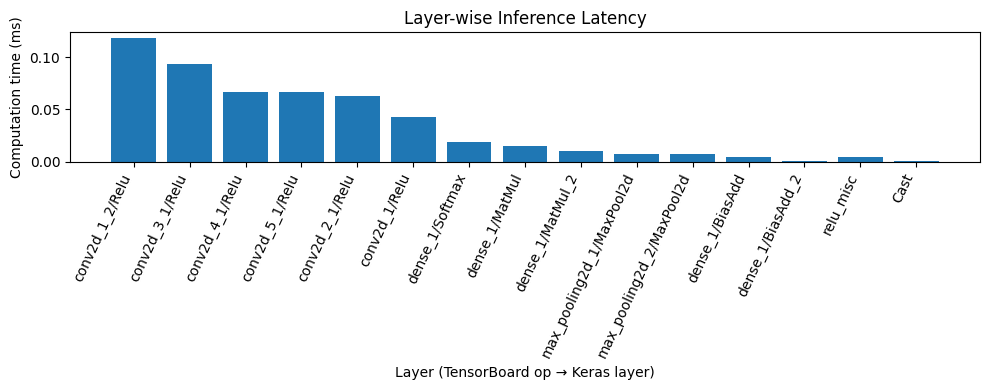

Figure: Layer-wise latency for one input (ms vs. layer).
Late/large Conv2D layers typically dominate total runtime,
consistent with the TensorBoard Op Stats breakdown.


In [ ]:
# Layer-wise latency analysis (example data from TensorBoard Framework Op Stats)
# TODO: Replace with actual data from your TensorBoard analysis
import matplotlib.pyplot as plt

# Example layers and times - replace these with your actual TensorBoard data
layers = [
    "conv2d_1_2/Relu",
    "conv2d_3_1/Relu",
    "conv2d_4_1/Relu",
    "conv2d_5_1/Relu",
    "conv2d_2_1/Relu",
    "conv2d_1/Relu",
    "dense_1/Softmax",
    "dense_1/MatMul",
    "dense_1/MatMul_2",
    "max_pooling2d_1/MaxPool2d",
    "max_pooling2d_2/MaxPool2d",
    "dense_1/BiasAdd",
    "dense_1/BiasAdd_2",
    "relu_misc",
    "Cast"
]

# Times taken from Total self-time on device report from TensorBoard (example values)
# TODO: Replace with your actual measured times from TensorBoard
times_us = [118, 94, 67, 67, 63, 43, 19, 15, 10, 7, 7, 4, 1, 4, 1]
times_ms = [t/1000.0 for t in times_us]

plt.figure(figsize=(max(10, 0.5*len(layers)), 4))
plt.bar(layers, times_ms)
plt.xticks(rotation=65, ha="right")
plt.ylabel("Computation time (ms)")
plt.xlabel("Layer (TensorBoard op → Keras layer)")
plt.title("Layer-wise Inference Latency")
plt.tight_layout()
plt.show()

print("Figure: Layer-wise latency for one input (ms vs. layer).")
print("Late/large Conv2D layers typically dominate total runtime,")
print("consistent with the TensorBoard Op Stats breakdown.")

**Figure 1:** Layer-wise latency for one input (ms vs. layer). Late/large Conv2D layers dominate total runtime, consistent with the TensorBoard Op Stats breakdown.

In [ ]:
# TODO: Sample Profiling - Online Inference:

# Vary this from 10, 100, 1000 to simulate multiple online inference
loop_index = [10, 100, 1000]

for idx in loop_index:
    print(f'\nProfiling {idx} online inferences...')

    # Starts Profile logging
    tf.profiler.experimental.start(log_dir_run)

    # Actual online inference - simulate real-time inference
    for i, example in enumerate(ds_val.batch(1).take(idx)):
        pred = model.predict(tf.cast(example["image"], tf.float32)/255.0, verbose=0)
        if i % 50 == 0:  # Print progress every 50 inferences
            print(f'  Completed {i+1}/{idx} inferences')

    # Stop profiling
    tf.profiler.experimental.stop()

    print(f'Completed {idx} online inferences. Profile saved to: {log_dir_run}')


Profiling 10 online inferences...
  Completed 1/10 inferences


2025-10-11 19:56:57.923326: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2025-10-11 19:56:57.923352: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2025-10-11 19:56:57.923375: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2025-10-11 19:56:57.923383: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2025-10-11 19:56:57.923387: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:223] cuptiGetResultString: ignored due to a previous error.
2025-10-11 19:56:57.923391: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1282] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 
2025-10-11 19:56:58.523516: W tensorflow/core/framework/local_rendezvous.cc:404] Local ren

Completed 10 online inferences. Profile saved to: /home/bbista22/Desktop/lab1/log_data/20251011-195652

Profiling 100 online inferences...
  Completed 1/100 inferences
  Completed 51/100 inferences


2025-10-11 19:57:04.099002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-11 19:57:04.099897: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2025-10-11 19:57:04.102537: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:142] cuptiFinalize: ignored due to a previous error.
2025-10-11 19:57:04.102556: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:223] cuptiGetResultString: ignored due to a previous error.
2025-10-11 19:57:04.102561: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1373] function cupti_interface_->Finalize()failed with error 
2025-10-11 19:57:04.129955: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2025-10-11 19:57:04.129994: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cup

Completed 100 online inferences. Profile saved to: /home/bbista22/Desktop/lab1/log_data/20251011-195652

Profiling 1000 online inferences...
  Completed 1/1000 inferences
  Completed 51/1000 inferences
  Completed 101/1000 inferences
  Completed 151/1000 inferences
  Completed 201/1000 inferences
  Completed 251/1000 inferences
  Completed 301/1000 inferences
  Completed 351/1000 inferences
  Completed 401/1000 inferences
  Completed 451/1000 inferences
  Completed 501/1000 inferences
  Completed 551/1000 inferences
  Completed 601/1000 inferences
  Completed 651/1000 inferences
  Completed 701/1000 inferences
  Completed 751/1000 inferences
  Completed 801/1000 inferences
  Completed 851/1000 inferences
  Completed 901/1000 inferences
  Completed 951/1000 inferences


2025-10-11 19:58:00.484392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-11 19:58:00.485679: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2025-10-11 19:58:00.492268: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:142] cuptiFinalize: ignored due to a previous error.
2025-10-11 19:58:00.492289: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:223] cuptiGetResultString: ignored due to a previous error.
2025-10-11 19:58:00.492294: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1373] function cupti_interface_->Finalize()failed with error 
2025-10-11 19:58:00.689798: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2025-10-11 19:58:00.689836: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cup

Completed 1000 online inferences. Profile saved to: /home/bbista22/Desktop/lab1/log_data/20251011-195652


In [ ]:
# TODO: Sample Profiling - Batch Inference:

# We would only perform batch inference for a subset of validation set i.e. 1000 images
# using different batch sizes of 20, 40, 100, 200

# Decides the size of the batch. Try: 20, 40, 100, 200
batch_sizes = [20, 40, 100, 200]

for batch_size in batch_sizes:
    print(f'\nProfiling batch inference with batch size: {batch_size}')

    # Starts Profile logging
    tf.profiler.experimental.start(log_dir_run)

    # Actual Batch inference - process 1000 images in batches
    total_images = 1000
    num_batches = total_images // batch_size

    for i, batch in enumerate(ds_val.batch(batch_size).take(num_batches)):
        pred = model.predict(tf.cast(batch["image"], tf.float32)/255.0, verbose=0)
        if i % 10 == 0:  # Print progress every 10 batches
            processed_images = (i + 1) * batch_size
            print(f'  Processed {processed_images}/{total_images} images in {i+1} batches')

    # Stop profiling
    tf.profiler.experimental.stop()

    print(f'Completed batch inference with batch size {batch_size}. Profile saved to: {log_dir_run}')


Profiling batch inference with batch size: 20


2025-10-11 19:58:00.992398: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2025-10-11 19:58:00.992429: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2025-10-11 19:58:00.992448: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2025-10-11 19:58:00.992453: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2025-10-11 19:58:00.992457: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:223] cuptiGetResultString: ignored due to a previous error.
2025-10-11 19:58:00.992461: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1282] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 


  Processed 20/1000 images in 1 batches
  Processed 220/1000 images in 11 batches
  Processed 420/1000 images in 21 batches
  Processed 620/1000 images in 31 batches
  Processed 820/1000 images in 41 batches


2025-10-11 19:58:05.348929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-11 19:58:05.350272: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2025-10-11 19:58:05.356920: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:142] cuptiFinalize: ignored due to a previous error.
2025-10-11 19:58:05.356942: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:223] cuptiGetResultString: ignored due to a previous error.
2025-10-11 19:58:05.356948: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1373] function cupti_interface_->Finalize()failed with error 
2025-10-11 19:58:05.400735: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2025-10-11 19:58:05.400761: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cup

Completed batch inference with batch size 20. Profile saved to: /home/bbista22/Desktop/lab1/log_data/20251011-195652

Profiling batch inference with batch size: 40
  Processed 40/1000 images in 1 batches
  Processed 440/1000 images in 11 batches
  Processed 840/1000 images in 21 batches


2025-10-11 19:58:07.235241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-11 19:58:07.236664: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2025-10-11 19:58:07.242507: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:142] cuptiFinalize: ignored due to a previous error.
2025-10-11 19:58:07.242530: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:223] cuptiGetResultString: ignored due to a previous error.
2025-10-11 19:58:07.242535: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1373] function cupti_interface_->Finalize()failed with error 
2025-10-11 19:58:07.284638: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2025-10-11 19:58:07.284681: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cup

Completed batch inference with batch size 40. Profile saved to: /home/bbista22/Desktop/lab1/log_data/20251011-195652

Profiling batch inference with batch size: 100
  Processed 100/1000 images in 1 batches


2025-10-11 19:58:08.964494: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-11 19:58:08.965367: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2025-10-11 19:58:08.971448: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:142] cuptiFinalize: ignored due to a previous error.
2025-10-11 19:58:08.971467: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:223] cuptiGetResultString: ignored due to a previous error.
2025-10-11 19:58:08.971472: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1373] function cupti_interface_->Finalize()failed with error 
2025-10-11 19:58:09.009428: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2025-10-11 19:58:09.009465: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cup

Completed batch inference with batch size 100. Profile saved to: /home/bbista22/Desktop/lab1/log_data/20251011-195652

Profiling batch inference with batch size: 200
  Processed 200/1000 images in 1 batches
Completed batch inference with batch size 200. Profile saved to: /home/bbista22/Desktop/lab1/log_data/20251011-195652


2025-10-11 19:58:09.524707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-11 19:58:09.525692: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2025-10-11 19:58:09.531205: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:142] cuptiFinalize: ignored due to a previous error.
2025-10-11 19:58:09.531223: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:223] cuptiGetResultString: ignored due to a previous error.
2025-10-11 19:58:09.531227: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1373] function cupti_interface_->Finalize()failed with error 
2025-10-11 19:58:09.565454: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2025-10-11 19:58:09.565495: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cup

## Training

In [ ]:
# Setup for model training
from tensorflow.keras import Model, datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, ZeroPadding2D,Convolution2D, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
train_dir = os.path.abspath(os.path.join('train_data', datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
pathlib.Path(train_dir).mkdir(exist_ok=True, parents=True)

# Using early stopping to monitor validation accuracy
callbacks = [
    ModelCheckpoint(
            filepath=os.path.join(train_dir, "best.weights.h5"),
            monitor="val_accuracy", mode="max",
            save_best_only=True, save_weights_only=True, verbose=1
    ),
    EarlyStopping(monitor="val_accuracy", mode="max", patience=7, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    TensorBoard(log_dir=train_dir, histogram_freq=1)
]

In [ ]:
# Basic CNN model
train_model = Sequential()

# conv1
train_model.add(Conv2D(32, (5, 5), input_shape=(64, 64, 3), activation='relu'))
train_model.add(Conv2D(32, (5,5),activation='relu'))
train_model.add(MaxPooling2D(pool_size=(2, 2)))
train_model.add(Conv2D(64, (3,3), activation='relu'))
train_model.add(Conv2D(64, (3,3), activation='relu'))
train_model.add(MaxPooling2D(pool_size=(2, 2)))
train_model.add(Conv2D(64, (3,3), activation='relu'))
train_model.add(Conv2D(128, (3,3), activation='relu'))
train_model.add(MaxPooling2D(pool_size=(2, 2)))
train_model.add(Flatten())

# fc1
train_model.add(Dense(256, activation='relu'))

# fc2
train_model.add(Dense(200, activation='softmax'))

train_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# TODO: Consider looking at different optimizers and learning rate settings
train_model.summary()

/home/bbista22/Desktop/lab1/lab1_venvGPU/lib64/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 60, 60, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        51,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 770,216 (2.94 MB)

 Trainable params: 770,216 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# TODO: Attempt to train your own model with different batch sizes
# TODO: See how long this takes without a GPU on your VDI or 2050 Coover machines
# TODO: THEN log in to your GPU VM, set ENABLE_GPU = False in the very first cell, and re-run all above cells
# TODO: Make sure you have exported the LD_LIBRARY_PATH as the lab manual indicates

import os, datetime
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy, SparseTopKCategoricalAccuracy

def make_optimizer(base_lr=3e-4, wd=1e-4):
    try:
        from tensorflow.keras.optimizers import AdamW
        return AdamW(learning_rate=base_lr, weight_decay=wd)
    except Exception:
        from tensorflow.keras.optimizers import Adam
        return Adam(learning_rate=base_lr)  # fallback if AdamW unavailable


# augment = tf.keras.Sequential([
#     tf.keras.layers.RandomFlip("horizontal"),
#     tf.keras.layers.RandomBrightness(0.1),
#     tf.keras.layers.RandomContrast(0.1),
# ])


ds_re = tiny_imagenet_builder.as_dataset(as_supervised=True)
ds_retrain, ds_reval = ds_re["train"], ds_re["validation"]

# Train DS
ds_retrain = ds_retrain.cache().shuffle(4096)
ds_retrain = ds_retrain.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, tf.cast(y, tf.int32)), #labels as integers because of SparseCategoricalCrossentropy and limits memory use
                            num_parallel_calls=tf.data.AUTOTUNE)
# Val DS 
ds_reval = ds_reval.cache()
ds_reval   = ds_reval.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, tf.cast(y, tf.int32)), #labels as integers because of SparseCategoricalCrossentropy and limits memory use
                          num_parallel_calls=tf.data.AUTOTUNE)

epoch_size = 30

for batch_size in [32]: #, 64, 128 in the next cell for longer runs 
    print(f'\n{"="*60}')
    print(f'Training with batch size: {batch_size}')
    print(f'{"="*60}')

    # Create a new model for each batch size experiment
    model_copy = tf.keras.models.clone_model(train_model)
    opt = make_optimizer() 
    model_copy.compile(
        loss=SparseCategoricalCrossentropy(),    # correct for integer labels
        optimizer=opt,
        metrics=[SparseCategoricalAccuracy(name="accuracy"),
             SparseTopKCategoricalAccuracy(k=5, name="top5_acc")]
    )

    # Setup our batched datasets
    train_batched = ds_retrain.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_batched   = ds_reval.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Record start time
    start_time = datetime.datetime.now()

    log_dir = os.path.abspath(os.path.join('train_data', datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

    history = model_copy.fit(
        train_batched,                    # full dataset (no .take)
        epochs=epoch_size,
        validation_data=val_batched,      # full validation (no .take)
        callbacks=callbacks,              # use the callbacks we set up earlier for modelcheckpointing, early stopping, etc.
        verbose=1
    )

    # Record end time
    end_time = datetime.datetime.now()
    training_time = end_time - start_time

    print(f'\nTraining completed for batch size {batch_size}')
    print(f'Training time: {training_time}')
    print(f'Final training accuracy: {history.history["accuracy"][-1]:.4f}')
    print(f'Final validation accuracy: {history.history["val_accuracy"][-1]:.4f}')

    # Save the model
    model_copy.save(os.path.join(train_dir, f'CNN_TinyImageNet_batch{batch_size}.h5'))
    print(f'Model saved as CNN_TinyImageNet_batch{batch_size}.h5')


Training with batch size: 32
Epoch 1/30
3116/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0224 - loss: 5.0516 - top5_acc: 0.0834

I0000 00:00:1760231384.265674 2405660 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_118', 16 bytes spill stores, 16 bytes spill loads




Epoch 1: val_accuracy improved from -inf to 0.08450, saving model to /home/bbista22/Desktop/lab1/train_data/20251011-200550/best.weights.h5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - accuracy: 0.0224 - loss: 5.0508 - top5_acc: 0.0836 - val_accuracy: 0.0845 - val_loss: 4.3796 - val_top5_acc: 0.2488 - learning_rate: 3.0000e-04
Epoch 2/30
3118/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1076 - loss: 4.2348 - top5_acc: 0.2902
Epoch 2: val_accuracy improved from 0.08450 to 0.15470, saving model to /home/bbista22/Desktop/lab1/train_data/20251011-200550/best.weights.h5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.1077 - loss: 4.2345 - top5_acc: 0.2903 - val_accuracy: 0.1547 - val_loss: 3.8749 - val_top5_acc: 0.3725 - learning_rate: 3.0000e-04
Epoch 3/30
3116/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1782 - loss: 3.7673 - top5_acc: 0.4060
Epoch 3: val_accuracy improved from 0.15470 to 0.19280, saving model to /home/bbista22/Desktop/lab1/train_data/20251011-20


Training completed for batch size 32
Training time: 0:05:24.363274
Final training accuracy: 0.6289
Final validation accuracy: 0.2410
Model saved as CNN_TinyImageNet_batch32.h5


In [ ]:
for batch_size in [64,128]: #, 64, 128]: 
    print(f'\n{"="*60}')
    print(f'Training with batch size: {batch_size}')
    print(f'{"="*60}')

    # Create a new model for each batch size experiment
    model_copy = tf.keras.models.clone_model(train_model)
    opt = make_optimizer() 
    model_copy.compile(
        loss=SparseCategoricalCrossentropy(),    # correct for integer labels
        optimizer=opt,
        metrics=[SparseCategoricalAccuracy(name="accuracy"),
             SparseTopKCategoricalAccuracy(k=5, name="top5_acc")]
    )

    # Setup our batched datasets
    train_batched = ds_retrain.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_batched   = ds_reval.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Record start time
    start_time = datetime.datetime.now()

    log_dir = os.path.abspath(os.path.join('train_data', datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

    history = model_copy.fit(
        train_batched,                    # full dataset (no .take)
        epochs=epoch_size,
        validation_data=val_batched,      # full validation (no .take)
        callbacks=callbacks,              # use the callbacks we set up earlier for modelcheckpointing, early stopping, etc.
        verbose=1
    )

    # Record end time
    end_time = datetime.datetime.now()
    training_time = end_time - start_time

    print(f'\nTraining completed for batch size {batch_size}')
    print(f'Training time: {training_time}')
    print(f'Final training accuracy: {history.history["accuracy"][-1]:.4f}')
    print(f'Final validation accuracy: {history.history["val_accuracy"][-1]:.4f}')

    # Save the model
    model_copy.save(os.path.join(train_dir, f'CNN_TinyImageNet_batch{batch_size}.h5'))
    print(f'Model saved as CNN_TinyImageNet_batch{batch_size}.h5')


Training with batch size: 64
Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0163 - loss: 5.1237 - top5_acc: 0.0662
Epoch 1: val_accuracy did not improve from 0.26390
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.0164 - loss: 5.1236 - top5_acc: 0.0662 - val_accuracy: 0.0686 - val_loss: 4.5309 - val_top5_acc: 0.2120 - learning_rate: 3.0000e-04
Epoch 2/10
1561/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0886 - loss: 4.4002 - top5_acc: 0.2496
Epoch 2: val_accuracy did not improve from 0.26390
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.0886 - loss: 4.3999 - top5_acc: 0.2496 - val_accuracy: 0.1343 - val_loss: 4.0542 - val_top5_acc: 0.3394 - learning_rate: 3.0000e-04
Epoch 3/10
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1514 - loss: 3.9371 - top5_acc: 0.3648
Epoch 3: val_accuracy did not improve from 0.26390
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.1514 - loss: 3.9370 - top5_acc: 0.3648 - val_accuracy: 0.


Training completed for batch size 64
Training time: 0:02:38.756743
Final training accuracy: 0.3679
Final validation accuracy: 0.2459
Model saved as CNN_TinyImageNet_batch64.h5

Training with batch size: 128
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0165 - loss: 5.1352 - top5_acc: 0.0653
Epoch 1: val_accuracy did not improve from 0.26390
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.0165 - loss: 5.1350 - top5_acc: 0.0654 - val_accuracy: 0.0741 - val_loss: 4.5730 - val_top5_acc: 0.2145 - learning_rate: 3.0000e-04
Epoch 2/10
780/782 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0863 - loss: 4.4521 - top5_acc: 0.2407
Epoch 2: val_accuracy did not improve from 0.26390
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.0864 - loss: 4.4517 - top5_acc: 0.2408 - val_accuracy: 0.1121 - val_loss: 4.2249 - val_top5_acc: 0.2943 - learning_rate: 3.0000e-04
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1378 - loss: 4.0682 - top5_acc: 0


Training completed for batch size 128
Training time: 0:02:00.503429
Final training accuracy: 0.3294
Final validation accuracy: 0.2490
Model saved as CNN_TinyImageNet_batch128.h5



Training with batch size 32 and epoch size: 3
Epoch 1/3
3122/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0179 - loss: 5.1031 - top5_acc: 0.0715
Epoch 1: val_accuracy did not improve from 0.26550
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - accuracy: 0.0179 - loss: 5.1028 - top5_acc: 0.0716 - val_accuracy: 0.0702 - val_loss: 4.5208 - val_top5_acc: 0.2145 - learning_rate: 3.0000e-04
Epoch 2/3
3122/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0952 - loss: 4.3498 - top5_acc: 0.2636
Epoch 2: val_accuracy did not improve from 0.26550
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.0952 - loss: 4.3496 - top5_acc: 0.2636 - val_accuracy: 0.1387 - val_loss: 4.0064 - val_top5_acc: 0.3518 - learning_rate: 3.0000e-04
Epoch 3/3
3122/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1619 - loss: 3.8832 - top5_acc: 0.3795
Epoch 3: val_accuracy did not improve from 0.26550
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.1619 - loss: 3.8830 - top5_acc: 0.3795 - val

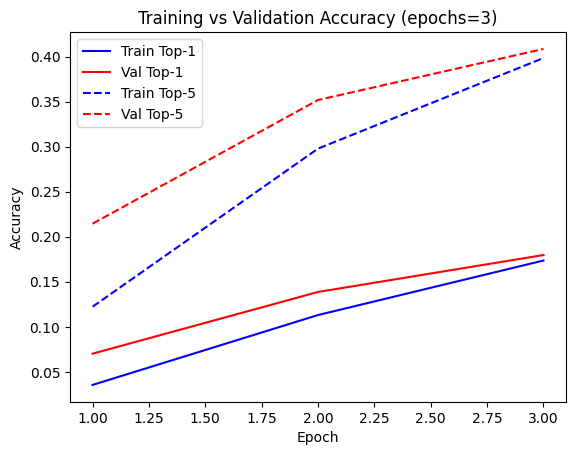

Model saved as CNN_TinyImageNet_batch32epoch3.h5

Training with batch size 32 and epoch size: 10
Epoch 1/10
3120/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0184 - loss: 5.1054 - top5_acc: 0.0708
Epoch 1: val_accuracy did not improve from 0.26550
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - accuracy: 0.0185 - loss: 5.1050 - top5_acc: 0.0709 - val_accuracy: 0.0794 - val_loss: 4.4756 - val_top5_acc: 0.2279 - learning_rate: 3.0000e-04
Epoch 2/10
3123/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0988 - loss: 4.3218 - top5_acc: 0.2708
Epoch 2: val_accuracy did not improve from 0.26550
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.0989 - loss: 4.3217 - top5_acc: 0.2709 - val_accuracy: 0.1507 - val_loss: 3.9380 - val_top5_acc: 0.3571 - learning_rate: 3.0000e-04
Epoch 3/10
3118/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1669 - loss: 3.8453 - top5_acc: 0.3875
Epoch 3: val_accuracy did not improve from 0.26550
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - acc

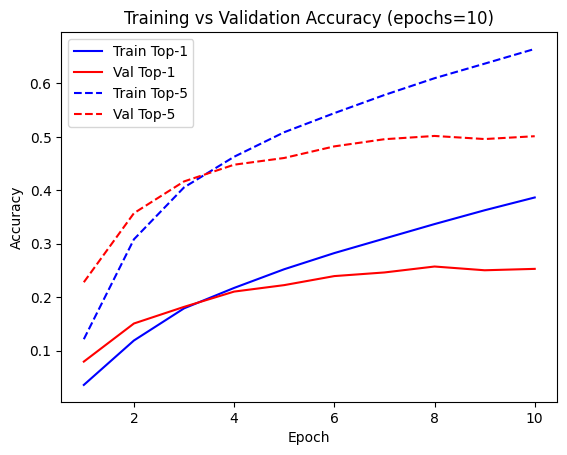

Model saved as CNN_TinyImageNet_batch32epoch10.h5

Training with batch size 32 and epoch size: 100
Epoch 1/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0194 - loss: 5.0858 - top5_acc: 0.0740
Epoch 1: val_accuracy did not improve from 0.26550
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - accuracy: 0.0194 - loss: 5.0857 - top5_acc: 0.0740 - val_accuracy: 0.0767 - val_loss: 4.4557 - val_top5_acc: 0.2323 - learning_rate: 3.0000e-04
Epoch 2/100
3121/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0999 - loss: 4.3105 - top5_acc: 0.2737
Epoch 2: val_accuracy did not improve from 0.26550
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.0999 - loss: 4.3103 - top5_acc: 0.2737 - val_accuracy: 0.1486 - val_loss: 3.9477 - val_top5_acc: 0.3600 - learning_rate: 3.0000e-04
Epoch 3/100
3123/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1657 - loss: 3.8396 - top5_acc: 0.3889
Epoch 3: val_accuracy did not improve from 0.26550
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step 

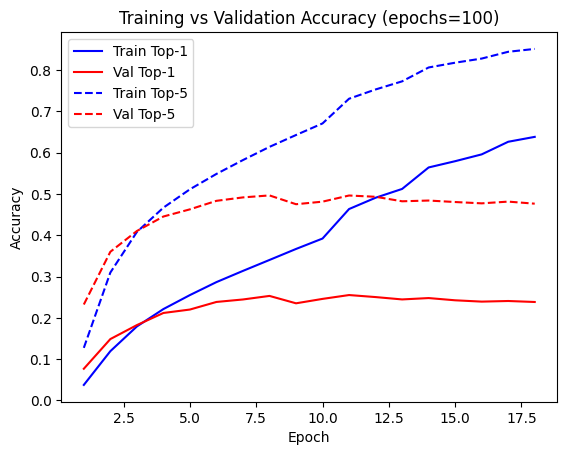

Model saved as CNN_TinyImageNet_batch32epoch100.h5


In [ ]:
import matplotlib.pyplot as plt # to plot training curves and get a better idea of training progress for different epoch sizes

# TODO: Train your model with 3 different numbers of epochs
batch_size = 32

# Setup your datasets
for epoch_size in [3,10,100]: 
    print(f'\n{"="*60}')
    print(f'Training with batch size 32 and epoch size: {epoch_size}')
    print(f'{"="*60}')

    tf.keras.backend.clear_session()

    # Create a new model for each epoch size experiment
    model_run = tf.keras.models.clone_model(train_model)
    opt = make_optimizer() 
    model_run.compile(
        loss=SparseCategoricalCrossentropy(),    # correct for integer labels
        optimizer=opt,                        # use the Adam optimizer with weight decay
        metrics=[SparseCategoricalAccuracy(name="accuracy"),
             SparseTopKCategoricalAccuracy(k=5, name="top5_acc")]
    )

    # Setup our batched datasets
    train_batched = ds_retrain.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_batched   = ds_reval.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Record start time
    start_time = datetime.datetime.now()

    log_dir = os.path.abspath(os.path.join('train_data', datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

    history = model_run.fit(
        train_batched,                    # full dataset (no .take)
        epochs=epoch_size,
        validation_data=val_batched,      # full validation (no .take)
        callbacks=callbacks,             # use the callbacks we set up earlier for modelcheckpointing, early stopping, etc.
        verbose=1
    )

    # Record end time
    end_time = datetime.datetime.now()
    training_time = end_time - start_time

    # Extract accuracy metrics for display and plotting
    top1_train = history.history.get('accuracy', [])
    top1_val   = history.history.get('val_accuracy', [])
    top5_train = history.history.get('top5_acc', [])
    top5_val   = history.history.get('val_top5_acc', [])
    print(f'\nTraining completed for batch size 32 with epoch size {epoch_size}')
    print(f'Training time: {training_time}')
    print(f'Final training accuracy: {history.history["accuracy"][-1]:.4f}')
    print(f'Final validation accuracy: {history.history["val_accuracy"][-1]:.4f}')
    print(f"[epochs={epoch_size}] "
      f"Train Top-1={top1_train[-1]:.4f}, Val Top-1={top1_val[-1]:.4f} | "
      f"Train Top-5={top5_train[-1]:.4f}, Val Top-5={top5_val[-1]:.4f}")


    
    # Plot training and validation accuracy curves for Top-1 and Top-5 visualization
    epochs = range(1, len(top1_val) + 1)
    plt.figure()
    plt.plot(epochs, top1_train, 'b-', label='Train Top-1')
    plt.plot(epochs, top1_val, 'r-', label='Val Top-1')
    plt.plot(epochs, top5_train, 'b--', label='Train Top-5')
    plt.plot(epochs, top5_val, 'r--', label='Val Top-5')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'Training vs Validation Accuracy (epochs={epoch_size})')
    plt.show()


    # Save the model
    model_run.save(os.path.join(log_dir, f'CNN_TinyImageNet_batch32epoch{epoch_size}.h5'))
    print(f'Model saved as CNN_TinyImageNet_batch32epoch{epoch_size}.h5')

In [ ]:
print("Metrics available:", model_run.metrics_names)


Metrics available: ['loss', 'compile_metrics']


## Above and Beyond

In [ ]:
# Benchmark our dataset to make sure loading our data isn't a bottleneck ... and because we can
# (This can be skipped since it can take a bit and is't all that important)

# tfds.benchmark(ds_train.batch(32), batch_size=32, num_iter=2**20)

In [ ]:
# Explore new models to find a higher-accuracy model. Does the new model require more or less time?